In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'full'

In [4]:
# Parameters
fs_type = "fsv34"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 148
Categorical features: 9
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0


Numerical Columns: 220
Categorical Columns: 9


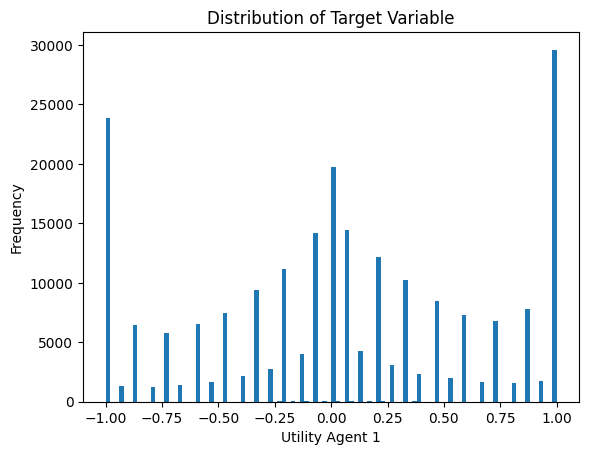

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6138352	test: 0.5483251	best: 0.5483251 (0)	total: 133ms	remaining: 6m 37s


50:	learn: 0.3886157	test: 0.4672358	best: 0.4672358 (50)	total: 4.26s	remaining: 4m 6s


100:	learn: 0.3482820	test: 0.4493442	best: 0.4493442 (100)	total: 8.69s	remaining: 4m 9s


150:	learn: 0.3238831	test: 0.4411110	best: 0.4411110 (150)	total: 13.1s	remaining: 4m 7s


200:	learn: 0.3082319	test: 0.4376065	best: 0.4376065 (200)	total: 17.6s	remaining: 4m 5s


250:	learn: 0.2965528	test: 0.4353420	best: 0.4353420 (250)	total: 22.1s	remaining: 4m 1s


300:	learn: 0.2871994	test: 0.4329249	best: 0.4329175 (299)	total: 26.5s	remaining: 3m 57s


350:	learn: 0.2799093	test: 0.4315041	best: 0.4315041 (350)	total: 31s	remaining: 3m 54s


400:	learn: 0.2734115	test: 0.4300895	best: 0.4300832 (399)	total: 35.6s	remaining: 3m 50s


450:	learn: 0.2672879	test: 0.4296626	best: 0.4296515 (448)	total: 40s	remaining: 3m 46s


500:	learn: 0.2624753	test: 0.4291205	best: 0.4290961 (494)	total: 44.5s	remaining: 3m 41s


550:	learn: 0.2573431	test: 0.4290329	best: 0.4290329 (550)	total: 49s	remaining: 3m 37s


600:	learn: 0.2527961	test: 0.4288393	best: 0.4287359 (598)	total: 53.6s	remaining: 3m 33s


650:	learn: 0.2480521	test: 0.4282205	best: 0.4281962 (648)	total: 57.9s	remaining: 3m 28s


700:	learn: 0.2447895	test: 0.4277995	best: 0.4277995 (700)	total: 1m 2s	remaining: 3m 24s


750:	learn: 0.2413903	test: 0.4278120	best: 0.4277393 (726)	total: 1m 6s	remaining: 3m 19s


800:	learn: 0.2378605	test: 0.4273246	best: 0.4273000 (796)	total: 1m 11s	remaining: 3m 15s


850:	learn: 0.2350844	test: 0.4271008	best: 0.4270060 (831)	total: 1m 15s	remaining: 3m 10s


900:	learn: 0.2322324	test: 0.4269765	best: 0.4269341 (876)	total: 1m 20s	remaining: 3m 6s


950:	learn: 0.2295142	test: 0.4267150	best: 0.4267150 (950)	total: 1m 24s	remaining: 3m 2s


1000:	learn: 0.2270863	test: 0.4266653	best: 0.4266325 (992)	total: 1m 28s	remaining: 2m 57s


1050:	learn: 0.2247229	test: 0.4267665	best: 0.4266325 (992)	total: 1m 33s	remaining: 2m 52s


1100:	learn: 0.2222925	test: 0.4268713	best: 0.4266325 (992)	total: 1m 37s	remaining: 2m 48s


1150:	learn: 0.2199658	test: 0.4265761	best: 0.4265761 (1150)	total: 1m 42s	remaining: 2m 43s


1200:	learn: 0.2177180	test: 0.4264240	best: 0.4264124 (1199)	total: 1m 46s	remaining: 2m 39s


1250:	learn: 0.2156467	test: 0.4262376	best: 0.4262221 (1245)	total: 1m 51s	remaining: 2m 35s


1300:	learn: 0.2135094	test: 0.4262392	best: 0.4262221 (1245)	total: 1m 55s	remaining: 2m 30s


1350:	learn: 0.2115049	test: 0.4261944	best: 0.4261781 (1330)	total: 1m 59s	remaining: 2m 26s


1400:	learn: 0.2096258	test: 0.4262294	best: 0.4261589 (1356)	total: 2m 4s	remaining: 2m 22s


1450:	learn: 0.2078250	test: 0.4260666	best: 0.4260618 (1448)	total: 2m 9s	remaining: 2m 17s


1500:	learn: 0.2061301	test: 0.4260584	best: 0.4260584 (1500)	total: 2m 13s	remaining: 2m 13s


1550:	learn: 0.2043078	test: 0.4259965	best: 0.4259482 (1542)	total: 2m 18s	remaining: 2m 8s


1600:	learn: 0.2024841	test: 0.4259185	best: 0.4258724 (1579)	total: 2m 22s	remaining: 2m 4s


1650:	learn: 0.2005941	test: 0.4258559	best: 0.4258290 (1625)	total: 2m 26s	remaining: 1m 59s


1700:	learn: 0.1989966	test: 0.4258267	best: 0.4258232 (1698)	total: 2m 30s	remaining: 1m 55s


1750:	learn: 0.1974967	test: 0.4256908	best: 0.4256747 (1748)	total: 2m 35s	remaining: 1m 50s


1800:	learn: 0.1959863	test: 0.4256359	best: 0.4256221 (1799)	total: 2m 39s	remaining: 1m 46s


1850:	learn: 0.1944374	test: 0.4255869	best: 0.4255623 (1844)	total: 2m 43s	remaining: 1m 41s


1900:	learn: 0.1930242	test: 0.4254649	best: 0.4254649 (1900)	total: 2m 48s	remaining: 1m 37s


1950:	learn: 0.1916179	test: 0.4254580	best: 0.4254493 (1932)	total: 2m 52s	remaining: 1m 32s


2000:	learn: 0.1902697	test: 0.4254821	best: 0.4254345 (1966)	total: 2m 56s	remaining: 1m 28s


2050:	learn: 0.1888399	test: 0.4254799	best: 0.4254345 (1966)	total: 3m 1s	remaining: 1m 23s


2100:	learn: 0.1875104	test: 0.4254578	best: 0.4254318 (2093)	total: 3m 5s	remaining: 1m 19s


2150:	learn: 0.1859815	test: 0.4255038	best: 0.4254126 (2119)	total: 3m 9s	remaining: 1m 14s


2200:	learn: 0.1847499	test: 0.4254963	best: 0.4254126 (2119)	total: 3m 14s	remaining: 1m 10s


2250:	learn: 0.1834845	test: 0.4254933	best: 0.4254126 (2119)	total: 3m 18s	remaining: 1m 6s


2300:	learn: 0.1820935	test: 0.4255712	best: 0.4254126 (2119)	total: 3m 22s	remaining: 1m 1s


2350:	learn: 0.1806680	test: 0.4255967	best: 0.4254126 (2119)	total: 3m 26s	remaining: 57.1s


2400:	learn: 0.1794164	test: 0.4256207	best: 0.4254126 (2119)	total: 3m 30s	remaining: 52.6s


2450:	learn: 0.1781849	test: 0.4256568	best: 0.4254126 (2119)	total: 3m 35s	remaining: 48.2s


2500:	learn: 0.1769908	test: 0.4257430	best: 0.4254126 (2119)	total: 3m 39s	remaining: 43.8s


2550:	learn: 0.1759391	test: 0.4256770	best: 0.4254126 (2119)	total: 3m 43s	remaining: 39.3s


2600:	learn: 0.1747096	test: 0.4257233	best: 0.4254126 (2119)	total: 3m 47s	remaining: 34.9s


2650:	learn: 0.1734972	test: 0.4257377	best: 0.4254126 (2119)	total: 3m 52s	remaining: 30.5s


2700:	learn: 0.1723918	test: 0.4257128	best: 0.4254126 (2119)	total: 3m 56s	remaining: 26.2s


2750:	learn: 0.1712598	test: 0.4256375	best: 0.4254126 (2119)	total: 4m	remaining: 21.8s


2800:	learn: 0.1703481	test: 0.4255988	best: 0.4254126 (2119)	total: 4m 4s	remaining: 17.4s


2850:	learn: 0.1691865	test: 0.4256889	best: 0.4254126 (2119)	total: 4m 8s	remaining: 13s


2900:	learn: 0.1681828	test: 0.4256924	best: 0.4254126 (2119)	total: 4m 13s	remaining: 8.64s


2950:	learn: 0.1672061	test: 0.4256954	best: 0.4254126 (2119)	total: 4m 17s	remaining: 4.28s


2999:	learn: 0.1662018	test: 0.4256761	best: 0.4254126 (2119)	total: 4m 21s	remaining: 0us

bestTest = 0.4254126237
bestIteration = 2119

Shrink model to first 2120 iterations.


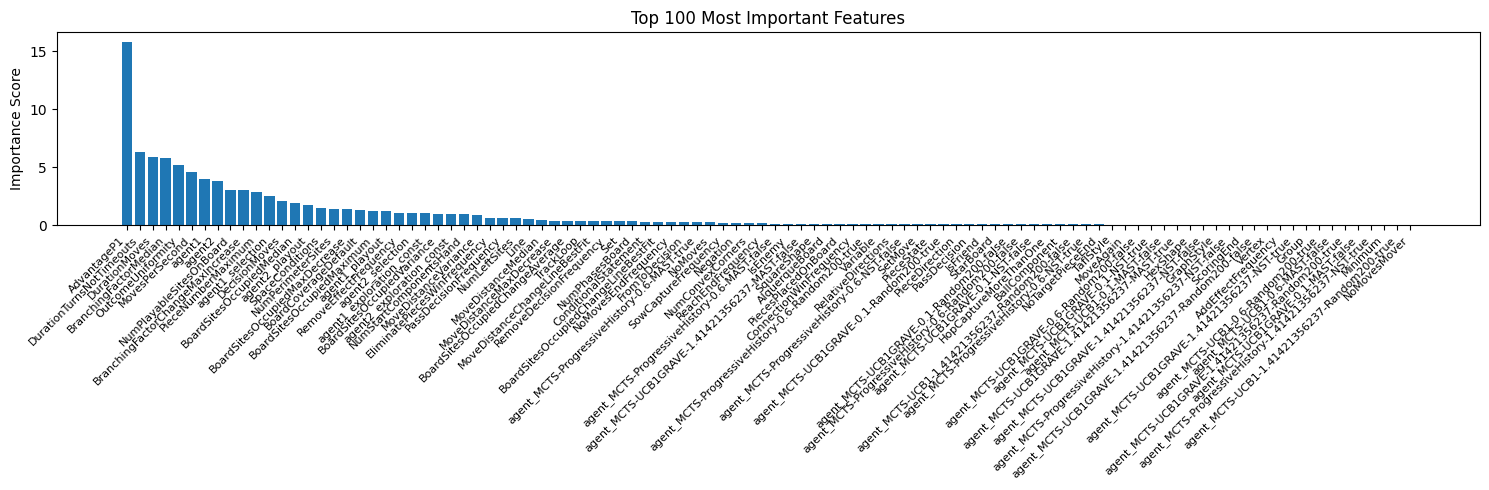

Fold 1 - RMSE: 0.4249006271164218
Fold 2


0:	learn: 0.6070174	test: 0.5802283	best: 0.5802283 (0)	total: 78.7ms	remaining: 3m 56s


50:	learn: 0.3941098	test: 0.4729460	best: 0.4729460 (50)	total: 3.89s	remaining: 3m 45s


100:	learn: 0.3525344	test: 0.4544549	best: 0.4544549 (100)	total: 7.97s	remaining: 3m 48s


150:	learn: 0.3298916	test: 0.4481449	best: 0.4481449 (150)	total: 12s	remaining: 3m 46s


200:	learn: 0.3145239	test: 0.4442594	best: 0.4442594 (200)	total: 16s	remaining: 3m 43s


250:	learn: 0.3031733	test: 0.4417930	best: 0.4417930 (250)	total: 20.1s	remaining: 3m 40s


300:	learn: 0.2935479	test: 0.4399871	best: 0.4399871 (300)	total: 24.2s	remaining: 3m 37s


350:	learn: 0.2861414	test: 0.4382609	best: 0.4382609 (350)	total: 28.4s	remaining: 3m 34s


400:	learn: 0.2791814	test: 0.4369594	best: 0.4369594 (400)	total: 32.4s	remaining: 3m 30s


450:	learn: 0.2734155	test: 0.4361702	best: 0.4361702 (450)	total: 36.5s	remaining: 3m 26s


500:	learn: 0.2681014	test: 0.4354064	best: 0.4353481 (492)	total: 40.6s	remaining: 3m 22s


550:	learn: 0.2630705	test: 0.4345144	best: 0.4345144 (550)	total: 44.8s	remaining: 3m 19s


600:	learn: 0.2585628	test: 0.4338426	best: 0.4338306 (599)	total: 49s	remaining: 3m 15s


650:	learn: 0.2544933	test: 0.4335067	best: 0.4334882 (649)	total: 53.2s	remaining: 3m 11s


700:	learn: 0.2506142	test: 0.4332303	best: 0.4332303 (700)	total: 57.4s	remaining: 3m 8s


750:	learn: 0.2472369	test: 0.4329373	best: 0.4329292 (744)	total: 1m 1s	remaining: 3m 4s


800:	learn: 0.2441916	test: 0.4325577	best: 0.4325577 (800)	total: 1m 5s	remaining: 3m


850:	learn: 0.2415174	test: 0.4324012	best: 0.4324012 (850)	total: 1m 10s	remaining: 2m 56s


900:	learn: 0.2386590	test: 0.4322648	best: 0.4322605 (891)	total: 1m 14s	remaining: 2m 52s


950:	learn: 0.2358708	test: 0.4322155	best: 0.4322155 (950)	total: 1m 18s	remaining: 2m 49s


1000:	learn: 0.2334594	test: 0.4320031	best: 0.4319814 (993)	total: 1m 23s	remaining: 2m 46s


1050:	learn: 0.2309131	test: 0.4317743	best: 0.4317554 (1049)	total: 1m 27s	remaining: 2m 42s


1100:	learn: 0.2287135	test: 0.4317163	best: 0.4317124 (1056)	total: 1m 31s	remaining: 2m 38s


1150:	learn: 0.2264700	test: 0.4315773	best: 0.4315628 (1149)	total: 1m 36s	remaining: 2m 34s


1200:	learn: 0.2240853	test: 0.4314776	best: 0.4313766 (1164)	total: 1m 40s	remaining: 2m 30s


1250:	learn: 0.2215807	test: 0.4313377	best: 0.4313174 (1247)	total: 1m 44s	remaining: 2m 25s


1300:	learn: 0.2194721	test: 0.4313062	best: 0.4312988 (1299)	total: 1m 48s	remaining: 2m 21s


1350:	learn: 0.2173567	test: 0.4310390	best: 0.4310269 (1324)	total: 1m 52s	remaining: 2m 17s


1400:	learn: 0.2153820	test: 0.4308436	best: 0.4308208 (1393)	total: 1m 56s	remaining: 2m 13s


1450:	learn: 0.2135441	test: 0.4308765	best: 0.4308123 (1403)	total: 2m	remaining: 2m 8s


1500:	learn: 0.2116473	test: 0.4308067	best: 0.4308067 (1500)	total: 2m 4s	remaining: 2m 4s


1550:	learn: 0.2098229	test: 0.4307368	best: 0.4307294 (1548)	total: 2m 8s	remaining: 2m


1600:	learn: 0.2080420	test: 0.4306797	best: 0.4306434 (1571)	total: 2m 13s	remaining: 1m 56s


1650:	learn: 0.2064812	test: 0.4306783	best: 0.4306434 (1571)	total: 2m 17s	remaining: 1m 52s


1700:	learn: 0.2048636	test: 0.4306235	best: 0.4306073 (1694)	total: 2m 21s	remaining: 1m 47s


1750:	learn: 0.2033423	test: 0.4306820	best: 0.4305994 (1720)	total: 2m 25s	remaining: 1m 43s


1800:	learn: 0.2017765	test: 0.4306728	best: 0.4305994 (1720)	total: 2m 29s	remaining: 1m 39s


1850:	learn: 0.2002031	test: 0.4306906	best: 0.4305994 (1720)	total: 2m 33s	remaining: 1m 35s


1900:	learn: 0.1986873	test: 0.4307467	best: 0.4305994 (1720)	total: 2m 37s	remaining: 1m 31s


1950:	learn: 0.1970918	test: 0.4307393	best: 0.4305994 (1720)	total: 2m 42s	remaining: 1m 27s


2000:	learn: 0.1957234	test: 0.4307204	best: 0.4305994 (1720)	total: 2m 46s	remaining: 1m 23s


2050:	learn: 0.1942030	test: 0.4308422	best: 0.4305994 (1720)	total: 2m 50s	remaining: 1m 18s


2100:	learn: 0.1928340	test: 0.4308362	best: 0.4305994 (1720)	total: 2m 54s	remaining: 1m 14s


2150:	learn: 0.1913526	test: 0.4307974	best: 0.4305994 (1720)	total: 2m 58s	remaining: 1m 10s


2200:	learn: 0.1899229	test: 0.4307626	best: 0.4305994 (1720)	total: 3m 2s	remaining: 1m 6s


2250:	learn: 0.1885749	test: 0.4307335	best: 0.4305994 (1720)	total: 3m 6s	remaining: 1m 2s


2300:	learn: 0.1872530	test: 0.4307982	best: 0.4305994 (1720)	total: 3m 11s	remaining: 58.1s


2350:	learn: 0.1859477	test: 0.4308446	best: 0.4305994 (1720)	total: 3m 15s	remaining: 53.9s


2400:	learn: 0.1846157	test: 0.4308321	best: 0.4305994 (1720)	total: 3m 19s	remaining: 49.7s


2450:	learn: 0.1833062	test: 0.4308030	best: 0.4305994 (1720)	total: 3m 23s	remaining: 45.5s


2500:	learn: 0.1820687	test: 0.4307972	best: 0.4305994 (1720)	total: 3m 27s	remaining: 41.4s


2550:	learn: 0.1808159	test: 0.4308162	best: 0.4305994 (1720)	total: 3m 31s	remaining: 37.2s


2600:	learn: 0.1795361	test: 0.4307335	best: 0.4305994 (1720)	total: 3m 35s	remaining: 33.1s


2650:	learn: 0.1783495	test: 0.4307710	best: 0.4305994 (1720)	total: 3m 39s	remaining: 28.9s


2700:	learn: 0.1772216	test: 0.4307841	best: 0.4305994 (1720)	total: 3m 43s	remaining: 24.8s


2750:	learn: 0.1759199	test: 0.4307723	best: 0.4305994 (1720)	total: 3m 47s	remaining: 20.6s


2800:	learn: 0.1748076	test: 0.4307613	best: 0.4305994 (1720)	total: 3m 51s	remaining: 16.5s


2850:	learn: 0.1736560	test: 0.4308569	best: 0.4305994 (1720)	total: 3m 55s	remaining: 12.3s


2900:	learn: 0.1725518	test: 0.4308810	best: 0.4305994 (1720)	total: 3m 59s	remaining: 8.19s


2950:	learn: 0.1714363	test: 0.4308616	best: 0.4305994 (1720)	total: 4m 4s	remaining: 4.05s


2999:	learn: 0.1703826	test: 0.4308649	best: 0.4305994 (1720)	total: 4m 8s	remaining: 0us

bestTest = 0.4305994133
bestIteration = 1720

Shrink model to first 1721 iterations.


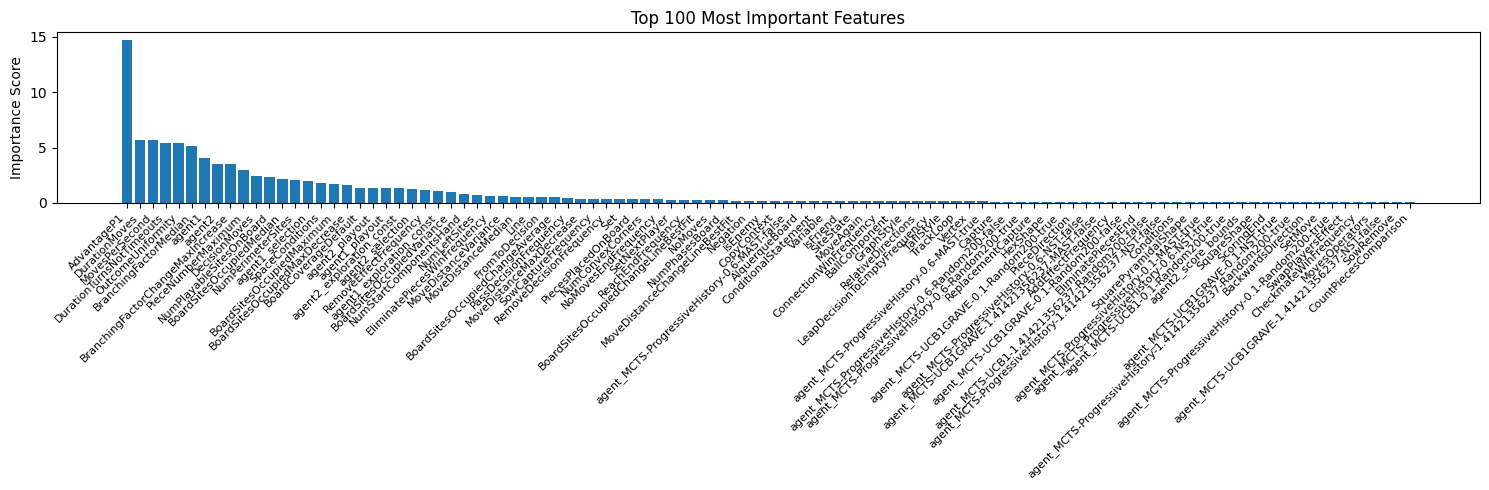

Fold 2 - RMSE: 0.429971545851476
Fold 3


0:	learn: 0.6028074	test: 0.5924652	best: 0.5924652 (0)	total: 75.3ms	remaining: 3m 45s


50:	learn: 0.3928588	test: 0.4570502	best: 0.4570502 (50)	total: 3.82s	remaining: 3m 40s


100:	learn: 0.3526886	test: 0.4398123	best: 0.4395196 (98)	total: 7.8s	remaining: 3m 44s


150:	learn: 0.3301805	test: 0.4309792	best: 0.4309792 (150)	total: 11.7s	remaining: 3m 40s


200:	learn: 0.3144451	test: 0.4274869	best: 0.4273674 (197)	total: 15.6s	remaining: 3m 37s


250:	learn: 0.3030418	test: 0.4250842	best: 0.4250566 (248)	total: 19.6s	remaining: 3m 34s


300:	learn: 0.2939234	test: 0.4239521	best: 0.4238260 (297)	total: 23.5s	remaining: 3m 31s


350:	learn: 0.2857171	test: 0.4223901	best: 0.4222676 (346)	total: 27.5s	remaining: 3m 27s


400:	learn: 0.2787965	test: 0.4216829	best: 0.4216829 (400)	total: 31.5s	remaining: 3m 24s


450:	learn: 0.2728999	test: 0.4208954	best: 0.4208167 (448)	total: 35.6s	remaining: 3m 20s


500:	learn: 0.2671929	test: 0.4200923	best: 0.4200923 (500)	total: 39.5s	remaining: 3m 16s


550:	learn: 0.2625151	test: 0.4192825	best: 0.4192825 (550)	total: 43.5s	remaining: 3m 13s


600:	learn: 0.2577484	test: 0.4187386	best: 0.4186641 (591)	total: 1m 14s	remaining: 4m 58s


650:	learn: 0.2536871	test: 0.4183809	best: 0.4183809 (650)	total: 1m 28s	remaining: 5m 17s


700:	learn: 0.2496893	test: 0.4176163	best: 0.4176163 (700)	total: 1m 31s	remaining: 5m 1s


750:	learn: 0.2460594	test: 0.4173281	best: 0.4173230 (748)	total: 1m 35s	remaining: 4m 47s


800:	learn: 0.2429517	test: 0.4172278	best: 0.4171994 (790)	total: 1m 39s	remaining: 4m 34s


850:	learn: 0.2399485	test: 0.4169724	best: 0.4169560 (846)	total: 1m 43s	remaining: 4m 22s


900:	learn: 0.2368807	test: 0.4168852	best: 0.4168852 (900)	total: 1m 47s	remaining: 4m 11s


950:	learn: 0.2341030	test: 0.4167759	best: 0.4166342 (938)	total: 1m 51s	remaining: 4m 1s


1000:	learn: 0.2317355	test: 0.4165112	best: 0.4165112 (1000)	total: 1m 55s	remaining: 3m 51s


1050:	learn: 0.2290179	test: 0.4163717	best: 0.4163717 (1050)	total: 1m 59s	remaining: 3m 42s


1100:	learn: 0.2265790	test: 0.4162892	best: 0.4162722 (1099)	total: 2m 30s	remaining: 4m 18s


1150:	learn: 0.2242140	test: 0.4161432	best: 0.4161142 (1133)	total: 3m 4s	remaining: 4m 56s


1200:	learn: 0.2219700	test: 0.4159630	best: 0.4158912 (1194)	total: 3m 10s	remaining: 4m 45s


1250:	learn: 0.2198937	test: 0.4159164	best: 0.4158912 (1194)	total: 3m 14s	remaining: 4m 32s


1300:	learn: 0.2178467	test: 0.4157322	best: 0.4157322 (1300)	total: 3m 18s	remaining: 4m 19s


1350:	learn: 0.2156536	test: 0.4154890	best: 0.4154890 (1350)	total: 3m 22s	remaining: 4m 7s


1400:	learn: 0.2136705	test: 0.4154052	best: 0.4153871 (1398)	total: 3m 26s	remaining: 3m 55s


1450:	learn: 0.2117718	test: 0.4153127	best: 0.4153006 (1447)	total: 3m 30s	remaining: 3m 44s


1500:	learn: 0.2099055	test: 0.4152039	best: 0.4151834 (1497)	total: 4m 6s	remaining: 4m 5s


1550:	learn: 0.2082184	test: 0.4151933	best: 0.4151392 (1543)	total: 4m 40s	remaining: 4m 22s


1600:	learn: 0.2065179	test: 0.4151257	best: 0.4151257 (1600)	total: 5m 16s	remaining: 4m 36s


1650:	learn: 0.2047927	test: 0.4150584	best: 0.4150576 (1647)	total: 5m 54s	remaining: 4m 49s


1700:	learn: 0.2031428	test: 0.4150223	best: 0.4149696 (1674)	total: 6m 38s	remaining: 5m 4s


1750:	learn: 0.2013509	test: 0.4150647	best: 0.4149696 (1674)	total: 7m 18s	remaining: 5m 12s


1800:	learn: 0.1997614	test: 0.4151188	best: 0.4149696 (1674)	total: 7m 53s	remaining: 5m 15s


1850:	learn: 0.1981584	test: 0.4151194	best: 0.4149696 (1674)	total: 7m 57s	remaining: 4m 56s


1900:	learn: 0.1966010	test: 0.4150022	best: 0.4149696 (1674)	total: 8m 1s	remaining: 4m 38s


1950:	learn: 0.1951363	test: 0.4150328	best: 0.4149696 (1674)	total: 8m 5s	remaining: 4m 20s


2000:	learn: 0.1937646	test: 0.4149477	best: 0.4149396 (1990)	total: 8m 8s	remaining: 4m 4s


2050:	learn: 0.1923844	test: 0.4148692	best: 0.4148692 (2050)	total: 8m 13s	remaining: 3m 48s


2100:	learn: 0.1911162	test: 0.4148142	best: 0.4148064 (2097)	total: 8m 17s	remaining: 3m 32s


2150:	learn: 0.1898235	test: 0.4147863	best: 0.4147690 (2146)	total: 8m 21s	remaining: 3m 17s


2200:	learn: 0.1884598	test: 0.4148687	best: 0.4147690 (2146)	total: 8m 25s	remaining: 3m 3s


2250:	learn: 0.1872662	test: 0.4148450	best: 0.4147690 (2146)	total: 8m 29s	remaining: 2m 49s


2300:	learn: 0.1858675	test: 0.4149001	best: 0.4147690 (2146)	total: 8m 33s	remaining: 2m 35s


2350:	learn: 0.1845304	test: 0.4148798	best: 0.4147690 (2146)	total: 8m 37s	remaining: 2m 22s


2400:	learn: 0.1832318	test: 0.4149003	best: 0.4147690 (2146)	total: 8m 41s	remaining: 2m 10s


2450:	learn: 0.1820201	test: 0.4149083	best: 0.4147690 (2146)	total: 8m 45s	remaining: 1m 57s


2500:	learn: 0.1807592	test: 0.4148199	best: 0.4147690 (2146)	total: 8m 49s	remaining: 1m 45s


2550:	learn: 0.1795386	test: 0.4147544	best: 0.4147146 (2526)	total: 8m 53s	remaining: 1m 33s


2600:	learn: 0.1783936	test: 0.4147289	best: 0.4147146 (2526)	total: 8m 57s	remaining: 1m 22s


2650:	learn: 0.1771877	test: 0.4147269	best: 0.4147146 (2526)	total: 9m 1s	remaining: 1m 11s


2700:	learn: 0.1760341	test: 0.4146947	best: 0.4146743 (2668)	total: 9m 5s	remaining: 1m


2750:	learn: 0.1749524	test: 0.4146950	best: 0.4146589 (2715)	total: 9m 9s	remaining: 49.7s


2800:	learn: 0.1738796	test: 0.4145600	best: 0.4145600 (2800)	total: 9m 13s	remaining: 39.3s


2850:	learn: 0.1728308	test: 0.4145373	best: 0.4145373 (2850)	total: 9m 17s	remaining: 29.1s


2900:	learn: 0.1717954	test: 0.4145301	best: 0.4145121 (2879)	total: 9m 21s	remaining: 19.2s


2950:	learn: 0.1708417	test: 0.4144918	best: 0.4144852 (2944)	total: 9m 25s	remaining: 9.38s


2999:	learn: 0.1698310	test: 0.4144807	best: 0.4144543 (2981)	total: 9m 29s	remaining: 0us

bestTest = 0.4144543059
bestIteration = 2981

Shrink model to first 2982 iterations.


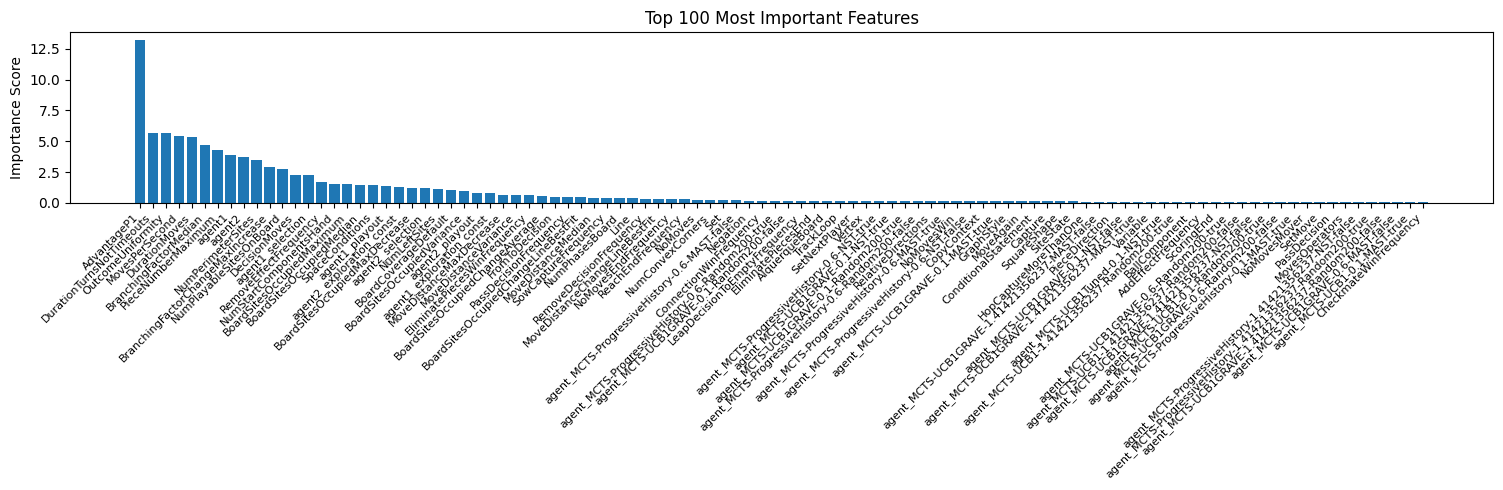

Fold 3 - RMSE: 0.4138439355329414
Fold 4


0:	learn: 0.6059264	test: 0.5861758	best: 0.5861758 (0)	total: 70.7ms	remaining: 3m 32s


50:	learn: 0.3856807	test: 0.4749274	best: 0.4749274 (50)	total: 3.56s	remaining: 3m 26s


100:	learn: 0.3480454	test: 0.4570103	best: 0.4570103 (100)	total: 7.26s	remaining: 3m 28s


150:	learn: 0.3268031	test: 0.4507380	best: 0.4507380 (150)	total: 10.9s	remaining: 3m 26s


200:	learn: 0.3124713	test: 0.4472801	best: 0.4472801 (200)	total: 14.7s	remaining: 3m 24s


250:	learn: 0.3005699	test: 0.4437365	best: 0.4437365 (250)	total: 18.4s	remaining: 3m 21s


300:	learn: 0.2912631	test: 0.4412695	best: 0.4412695 (300)	total: 22.2s	remaining: 3m 19s


350:	learn: 0.2835925	test: 0.4397679	best: 0.4397679 (350)	total: 26s	remaining: 3m 16s


400:	learn: 0.2766653	test: 0.4379423	best: 0.4379423 (400)	total: 29.8s	remaining: 3m 13s


450:	learn: 0.2702730	test: 0.4367024	best: 0.4367024 (450)	total: 33.7s	remaining: 3m 10s


500:	learn: 0.2646480	test: 0.4356477	best: 0.4356350 (498)	total: 37.4s	remaining: 3m 6s


550:	learn: 0.2596951	test: 0.4351850	best: 0.4351708 (549)	total: 41.3s	remaining: 3m 3s


600:	learn: 0.2555375	test: 0.4349456	best: 0.4349097 (572)	total: 45.2s	remaining: 3m


650:	learn: 0.2513764	test: 0.4342981	best: 0.4342981 (650)	total: 49.1s	remaining: 2m 57s


700:	learn: 0.2475433	test: 0.4337233	best: 0.4337233 (700)	total: 52.9s	remaining: 2m 53s


750:	learn: 0.2440751	test: 0.4332321	best: 0.4332248 (744)	total: 56.8s	remaining: 2m 49s


800:	learn: 0.2408929	test: 0.4329097	best: 0.4329057 (797)	total: 1m	remaining: 2m 46s


850:	learn: 0.2376581	test: 0.4323305	best: 0.4323305 (850)	total: 1m 4s	remaining: 2m 42s


900:	learn: 0.2344982	test: 0.4320320	best: 0.4320320 (900)	total: 1m 8s	remaining: 2m 39s


950:	learn: 0.2318811	test: 0.4318426	best: 0.4318125 (948)	total: 1m 12s	remaining: 2m 35s


1000:	learn: 0.2293196	test: 0.4317789	best: 0.4317493 (985)	total: 1m 16s	remaining: 2m 32s


1050:	learn: 0.2266335	test: 0.4314497	best: 0.4314497 (1050)	total: 1m 20s	remaining: 2m 28s


1100:	learn: 0.2244325	test: 0.4313546	best: 0.4313504 (1099)	total: 1m 23s	remaining: 2m 24s


1150:	learn: 0.2220542	test: 0.4311987	best: 0.4311726 (1124)	total: 1m 27s	remaining: 2m 21s


1200:	learn: 0.2199063	test: 0.4310948	best: 0.4310735 (1199)	total: 1m 31s	remaining: 2m 17s


1250:	learn: 0.2177568	test: 0.4309578	best: 0.4309578 (1250)	total: 1m 35s	remaining: 2m 13s


1300:	learn: 0.2158916	test: 0.4308872	best: 0.4308764 (1295)	total: 1m 39s	remaining: 2m 10s


1350:	learn: 0.2139521	test: 0.4307604	best: 0.4307396 (1334)	total: 1m 43s	remaining: 2m 6s


1400:	learn: 0.2122185	test: 0.4306228	best: 0.4306125 (1399)	total: 1m 47s	remaining: 2m 2s


1450:	learn: 0.2103493	test: 0.4305805	best: 0.4305677 (1414)	total: 1m 51s	remaining: 1m 58s


1500:	learn: 0.2084795	test: 0.4305169	best: 0.4305169 (1500)	total: 1m 55s	remaining: 1m 54s


1550:	learn: 0.2066891	test: 0.4303478	best: 0.4303213 (1543)	total: 1m 59s	remaining: 1m 51s


1600:	learn: 0.2049181	test: 0.4303095	best: 0.4302992 (1567)	total: 2m 2s	remaining: 1m 47s


1650:	learn: 0.2034064	test: 0.4302537	best: 0.4302537 (1650)	total: 2m 6s	remaining: 1m 43s


1700:	learn: 0.2019160	test: 0.4303297	best: 0.4302520 (1652)	total: 2m 10s	remaining: 1m 39s


1750:	learn: 0.2002787	test: 0.4302413	best: 0.4302309 (1748)	total: 2m 14s	remaining: 1m 36s


1800:	learn: 0.1989736	test: 0.4303019	best: 0.4302309 (1748)	total: 2m 18s	remaining: 1m 32s


1850:	learn: 0.1975595	test: 0.4302477	best: 0.4302309 (1748)	total: 2m 22s	remaining: 1m 28s


1900:	learn: 0.1960931	test: 0.4301417	best: 0.4301364 (1899)	total: 2m 26s	remaining: 1m 24s


1950:	learn: 0.1947091	test: 0.4301414	best: 0.4300959 (1943)	total: 2m 30s	remaining: 1m 20s


2000:	learn: 0.1932280	test: 0.4299770	best: 0.4299691 (1975)	total: 2m 34s	remaining: 1m 16s


2050:	learn: 0.1918131	test: 0.4299558	best: 0.4299207 (2028)	total: 2m 38s	remaining: 1m 13s


2100:	learn: 0.1904360	test: 0.4298884	best: 0.4298884 (2100)	total: 2m 42s	remaining: 1m 9s


2150:	learn: 0.1890347	test: 0.4298929	best: 0.4298511 (2132)	total: 2m 45s	remaining: 1m 5s


2200:	learn: 0.1878101	test: 0.4298531	best: 0.4298480 (2196)	total: 2m 49s	remaining: 1m 1s


2250:	learn: 0.1864767	test: 0.4298501	best: 0.4298339 (2242)	total: 2m 53s	remaining: 57.8s


2300:	learn: 0.1851281	test: 0.4297899	best: 0.4297873 (2299)	total: 2m 57s	remaining: 53.9s


2350:	learn: 0.1839290	test: 0.4298010	best: 0.4297753 (2319)	total: 3m 1s	remaining: 50.1s


2400:	learn: 0.1825927	test: 0.4297962	best: 0.4297753 (2319)	total: 3m 5s	remaining: 46.3s


2450:	learn: 0.1813732	test: 0.4298314	best: 0.4297653 (2445)	total: 3m 9s	remaining: 42.4s


2500:	learn: 0.1802134	test: 0.4298409	best: 0.4297653 (2445)	total: 3m 13s	remaining: 38.6s


2550:	learn: 0.1789492	test: 0.4298546	best: 0.4297653 (2445)	total: 3m 17s	remaining: 34.7s


2600:	learn: 0.1779105	test: 0.4298334	best: 0.4297653 (2445)	total: 3m 21s	remaining: 30.9s


2650:	learn: 0.1767583	test: 0.4298066	best: 0.4297653 (2445)	total: 3m 24s	remaining: 27s


2700:	learn: 0.1756488	test: 0.4298078	best: 0.4297653 (2445)	total: 3m 28s	remaining: 23.1s


2750:	learn: 0.1746495	test: 0.4298145	best: 0.4297653 (2445)	total: 3m 32s	remaining: 19.3s


2800:	learn: 0.1735625	test: 0.4298295	best: 0.4297653 (2445)	total: 3m 37s	remaining: 15.4s


2850:	learn: 0.1725594	test: 0.4298826	best: 0.4297653 (2445)	total: 3m 41s	remaining: 11.6s


2900:	learn: 0.1714549	test: 0.4299131	best: 0.4297653 (2445)	total: 3m 45s	remaining: 7.68s


2950:	learn: 0.1703455	test: 0.4299552	best: 0.4297653 (2445)	total: 3m 48s	remaining: 3.8s


2999:	learn: 0.1694279	test: 0.4299603	best: 0.4297653 (2445)	total: 3m 52s	remaining: 0us

bestTest = 0.4297652909
bestIteration = 2445

Shrink model to first 2446 iterations.


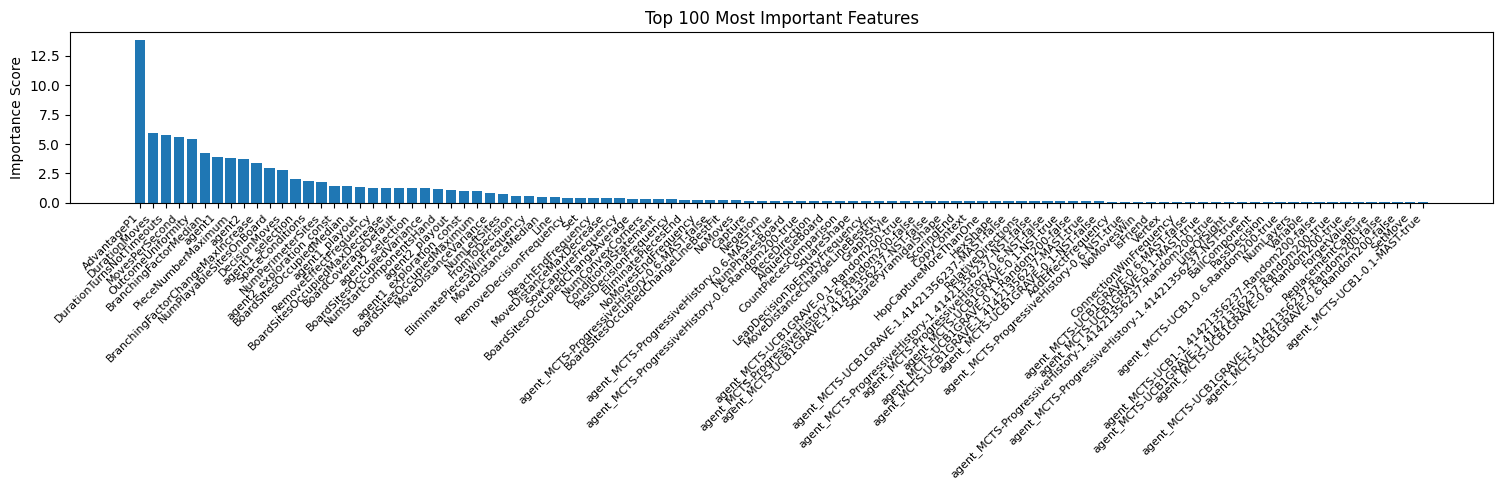

Fold 4 - RMSE: 0.4288104967395605
Fold 5


0:	learn: 0.6174546	test: 0.5425570	best: 0.5425570 (0)	total: 65.9ms	remaining: 3m 17s


50:	learn: 0.3993072	test: 0.4502543	best: 0.4502543 (50)	total: 3.6s	remaining: 3m 28s


100:	learn: 0.3584597	test: 0.4311013	best: 0.4311013 (100)	total: 7.3s	remaining: 3m 29s


150:	learn: 0.3352910	test: 0.4228938	best: 0.4228938 (150)	total: 11.1s	remaining: 3m 28s


200:	learn: 0.3192594	test: 0.4180357	best: 0.4180357 (200)	total: 14.8s	remaining: 3m 26s


250:	learn: 0.3078914	test: 0.4161094	best: 0.4161094 (250)	total: 18.6s	remaining: 3m 23s


300:	learn: 0.2984807	test: 0.4143847	best: 0.4143847 (300)	total: 22.4s	remaining: 3m 20s


350:	learn: 0.2902473	test: 0.4132670	best: 0.4132230 (346)	total: 26.2s	remaining: 3m 17s


400:	learn: 0.2832036	test: 0.4121000	best: 0.4121000 (400)	total: 30s	remaining: 3m 14s


450:	learn: 0.2768679	test: 0.4111070	best: 0.4111070 (450)	total: 33.8s	remaining: 3m 10s


500:	learn: 0.2711533	test: 0.4105317	best: 0.4105230 (498)	total: 37.5s	remaining: 3m 7s


550:	learn: 0.2659160	test: 0.4099152	best: 0.4099152 (550)	total: 41.4s	remaining: 3m 3s


600:	learn: 0.2610130	test: 0.4089080	best: 0.4089080 (600)	total: 45.2s	remaining: 3m


650:	learn: 0.2570487	test: 0.4085473	best: 0.4085473 (650)	total: 49s	remaining: 2m 56s


700:	learn: 0.2531586	test: 0.4078092	best: 0.4078092 (700)	total: 52.9s	remaining: 2m 53s


750:	learn: 0.2498198	test: 0.4076260	best: 0.4075564 (732)	total: 56.8s	remaining: 2m 49s


800:	learn: 0.2460643	test: 0.4073953	best: 0.4072766 (787)	total: 1m	remaining: 2m 46s


850:	learn: 0.2427636	test: 0.4071742	best: 0.4071487 (838)	total: 1m 4s	remaining: 2m 42s


900:	learn: 0.2395553	test: 0.4068255	best: 0.4068255 (900)	total: 1m 8s	remaining: 2m 38s


950:	learn: 0.2364874	test: 0.4065158	best: 0.4065158 (950)	total: 1m 12s	remaining: 2m 35s


1000:	learn: 0.2338009	test: 0.4065374	best: 0.4064174 (980)	total: 1m 15s	remaining: 2m 31s


1050:	learn: 0.2309565	test: 0.4063151	best: 0.4063151 (1050)	total: 1m 19s	remaining: 2m 28s


1100:	learn: 0.2282213	test: 0.4062247	best: 0.4061425 (1085)	total: 1m 23s	remaining: 2m 24s


1150:	learn: 0.2258873	test: 0.4060657	best: 0.4060451 (1145)	total: 1m 27s	remaining: 2m 20s


1200:	learn: 0.2235828	test: 0.4056830	best: 0.4056830 (1200)	total: 1m 31s	remaining: 2m 16s


1250:	learn: 0.2214412	test: 0.4055400	best: 0.4055354 (1248)	total: 1m 35s	remaining: 2m 13s


1300:	learn: 0.2191256	test: 0.4054718	best: 0.4054162 (1295)	total: 1m 39s	remaining: 2m 9s


1350:	learn: 0.2170657	test: 0.4054870	best: 0.4054162 (1295)	total: 1m 43s	remaining: 2m 5s


1400:	learn: 0.2153588	test: 0.4053127	best: 0.4053127 (1400)	total: 1m 47s	remaining: 2m 2s


1450:	learn: 0.2133945	test: 0.4052955	best: 0.4052149 (1428)	total: 1m 50s	remaining: 1m 58s


1500:	learn: 0.2114178	test: 0.4052130	best: 0.4052099 (1493)	total: 1m 54s	remaining: 1m 54s


1550:	learn: 0.2096378	test: 0.4051570	best: 0.4051045 (1534)	total: 1m 58s	remaining: 1m 50s


1600:	learn: 0.2079491	test: 0.4051185	best: 0.4050662 (1578)	total: 2m 2s	remaining: 1m 47s


1650:	learn: 0.2062917	test: 0.4053787	best: 0.4050662 (1578)	total: 2m 6s	remaining: 1m 43s


1700:	learn: 0.2046665	test: 0.4052874	best: 0.4050662 (1578)	total: 2m 10s	remaining: 1m 39s


1750:	learn: 0.2030466	test: 0.4052194	best: 0.4050662 (1578)	total: 2m 14s	remaining: 1m 35s


1800:	learn: 0.2012402	test: 0.4051758	best: 0.4050662 (1578)	total: 2m 18s	remaining: 1m 31s


1850:	learn: 0.1996209	test: 0.4051714	best: 0.4050662 (1578)	total: 2m 21s	remaining: 1m 28s


1900:	learn: 0.1980600	test: 0.4050658	best: 0.4050658 (1900)	total: 2m 25s	remaining: 1m 24s


1950:	learn: 0.1963994	test: 0.4050744	best: 0.4050271 (1937)	total: 2m 29s	remaining: 1m 20s


2000:	learn: 0.1949627	test: 0.4049747	best: 0.4049659 (1999)	total: 2m 33s	remaining: 1m 16s


2050:	learn: 0.1936616	test: 0.4049534	best: 0.4049249 (2013)	total: 2m 37s	remaining: 1m 12s


2100:	learn: 0.1921868	test: 0.4048879	best: 0.4048673 (2081)	total: 2m 41s	remaining: 1m 9s


2150:	learn: 0.1905954	test: 0.4049662	best: 0.4048673 (2081)	total: 2m 45s	remaining: 1m 5s


2200:	learn: 0.1892728	test: 0.4049653	best: 0.4048673 (2081)	total: 2m 49s	remaining: 1m 1s


2250:	learn: 0.1879389	test: 0.4049058	best: 0.4048673 (2081)	total: 2m 53s	remaining: 57.6s


2300:	learn: 0.1865824	test: 0.4049130	best: 0.4048673 (2081)	total: 2m 56s	remaining: 53.7s


2350:	learn: 0.1853500	test: 0.4048985	best: 0.4048621 (2330)	total: 3m	remaining: 49.9s


2400:	learn: 0.1839879	test: 0.4048083	best: 0.4048045 (2391)	total: 3m 4s	remaining: 46.1s


2450:	learn: 0.1827008	test: 0.4048242	best: 0.4048045 (2391)	total: 3m 8s	remaining: 42.2s


2500:	learn: 0.1814755	test: 0.4048338	best: 0.4047915 (2456)	total: 3m 12s	remaining: 38.4s


2550:	learn: 0.1802295	test: 0.4049005	best: 0.4047915 (2456)	total: 3m 16s	remaining: 34.6s


2600:	learn: 0.1791563	test: 0.4048376	best: 0.4047915 (2456)	total: 3m 20s	remaining: 30.7s


2650:	learn: 0.1780730	test: 0.4048135	best: 0.4047915 (2456)	total: 3m 24s	remaining: 26.9s


2700:	learn: 0.1768975	test: 0.4048020	best: 0.4047829 (2689)	total: 3m 28s	remaining: 23s


2750:	learn: 0.1758001	test: 0.4047697	best: 0.4047697 (2750)	total: 3m 32s	remaining: 19.2s


2800:	learn: 0.1746004	test: 0.4047872	best: 0.4047254 (2772)	total: 3m 35s	remaining: 15.3s


2850:	learn: 0.1735241	test: 0.4048885	best: 0.4047254 (2772)	total: 3m 39s	remaining: 11.5s


2900:	learn: 0.1724460	test: 0.4048925	best: 0.4047254 (2772)	total: 3m 43s	remaining: 7.63s


2950:	learn: 0.1713876	test: 0.4048833	best: 0.4047254 (2772)	total: 3m 47s	remaining: 3.78s


2999:	learn: 0.1703743	test: 0.4047931	best: 0.4047254 (2772)	total: 3m 51s	remaining: 0us

bestTest = 0.4047253797
bestIteration = 2772

Shrink model to first 2773 iterations.


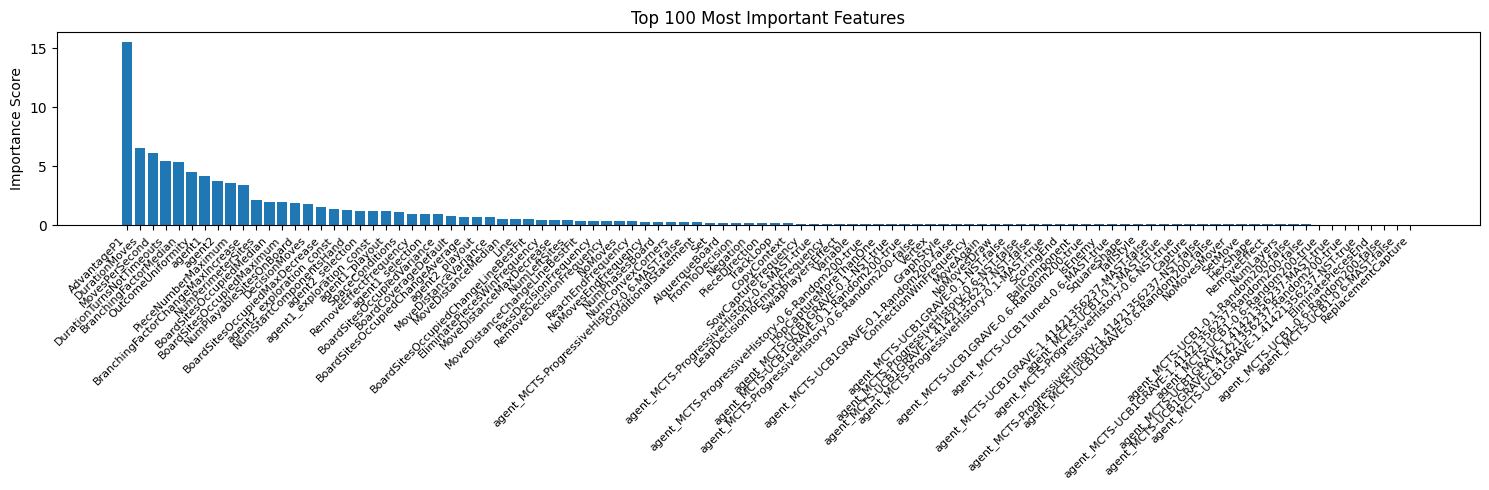

Fold 5 - RMSE: 0.4042833177576968
List of oof scores: [0.4249006271164218, 0.429971545851476, 0.4138439355329414, 0.4288104967395605, 0.4042833177576968]
Average oof score: 0.4203619845996194


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6188496	test: 0.5303419	best: 0.5303419 (0)	total: 67.9ms	remaining: 3m 23s


50:	learn: 0.3941243	test: 0.4431111	best: 0.4431111 (50)	total: 3.55s	remaining: 3m 25s


100:	learn: 0.3542838	test: 0.4302768	best: 0.4302768 (100)	total: 7.27s	remaining: 3m 28s


150:	learn: 0.3296279	test: 0.4250094	best: 0.4250094 (150)	total: 10.9s	remaining: 3m 25s


200:	learn: 0.3140521	test: 0.4216358	best: 0.4216023 (194)	total: 14.6s	remaining: 3m 22s


250:	learn: 0.3022908	test: 0.4195424	best: 0.4195424 (250)	total: 18.3s	remaining: 3m 20s


300:	learn: 0.2916572	test: 0.4168892	best: 0.4168892 (300)	total: 21.9s	remaining: 3m 16s


350:	learn: 0.2833961	test: 0.4153475	best: 0.4153346 (348)	total: 25.6s	remaining: 3m 13s


400:	learn: 0.2765619	test: 0.4140337	best: 0.4140337 (400)	total: 29.3s	remaining: 3m 10s


450:	learn: 0.2702044	test: 0.4125308	best: 0.4125308 (450)	total: 33s	remaining: 3m 6s


500:	learn: 0.2646232	test: 0.4117417	best: 0.4117417 (500)	total: 36.8s	remaining: 3m 3s


550:	learn: 0.2594081	test: 0.4110475	best: 0.4110475 (550)	total: 40.5s	remaining: 2m 59s


600:	learn: 0.2549837	test: 0.4105004	best: 0.4105004 (600)	total: 44.3s	remaining: 2m 56s


650:	learn: 0.2505679	test: 0.4102813	best: 0.4102508 (612)	total: 48s	remaining: 2m 53s


700:	learn: 0.2469939	test: 0.4101354	best: 0.4101277 (699)	total: 51.8s	remaining: 2m 49s


750:	learn: 0.2435336	test: 0.4100177	best: 0.4099847 (747)	total: 55.6s	remaining: 2m 46s


800:	learn: 0.2403318	test: 0.4098588	best: 0.4098492 (795)	total: 59.5s	remaining: 2m 43s


850:	learn: 0.2371715	test: 0.4095430	best: 0.4095430 (850)	total: 1m 3s	remaining: 2m 39s


900:	learn: 0.2339216	test: 0.4091592	best: 0.4091592 (900)	total: 1m 6s	remaining: 2m 36s


950:	learn: 0.2315009	test: 0.4089882	best: 0.4089882 (950)	total: 1m 10s	remaining: 2m 32s


1000:	learn: 0.2289987	test: 0.4089726	best: 0.4089109 (965)	total: 1m 14s	remaining: 2m 29s


1050:	learn: 0.2261290	test: 0.4087207	best: 0.4087207 (1050)	total: 1m 18s	remaining: 2m 25s


1100:	learn: 0.2236897	test: 0.4083183	best: 0.4082865 (1099)	total: 1m 22s	remaining: 2m 22s


1150:	learn: 0.2215746	test: 0.4081633	best: 0.4081158 (1146)	total: 1m 26s	remaining: 2m 18s


1200:	learn: 0.2193069	test: 0.4081449	best: 0.4080322 (1168)	total: 1m 30s	remaining: 2m 14s


1250:	learn: 0.2170444	test: 0.4080378	best: 0.4080313 (1249)	total: 1m 33s	remaining: 2m 11s


1300:	learn: 0.2148063	test: 0.4079464	best: 0.4079082 (1292)	total: 1m 37s	remaining: 2m 7s


1350:	learn: 0.2126600	test: 0.4077968	best: 0.4077917 (1348)	total: 1m 41s	remaining: 2m 3s


1400:	learn: 0.2107385	test: 0.4077696	best: 0.4077211 (1394)	total: 1m 45s	remaining: 2m


1450:	learn: 0.2087364	test: 0.4076511	best: 0.4076301 (1447)	total: 1m 49s	remaining: 1m 56s


1500:	learn: 0.2068786	test: 0.4075909	best: 0.4075883 (1488)	total: 1m 52s	remaining: 1m 52s


1550:	learn: 0.2051336	test: 0.4074587	best: 0.4074501 (1549)	total: 1m 56s	remaining: 1m 48s


1600:	learn: 0.2034023	test: 0.4074199	best: 0.4074199 (1600)	total: 2m	remaining: 1m 45s


1650:	learn: 0.2017820	test: 0.4074094	best: 0.4073799 (1641)	total: 2m 4s	remaining: 1m 41s


1700:	learn: 0.1999825	test: 0.4073129	best: 0.4073107 (1698)	total: 2m 8s	remaining: 1m 37s


1750:	learn: 0.1985354	test: 0.4072809	best: 0.4072809 (1750)	total: 2m 11s	remaining: 1m 34s


1800:	learn: 0.1970499	test: 0.4073003	best: 0.4072501 (1782)	total: 2m 15s	remaining: 1m 30s


1850:	learn: 0.1955776	test: 0.4073047	best: 0.4072501 (1782)	total: 2m 19s	remaining: 1m 26s


1900:	learn: 0.1939068	test: 0.4072162	best: 0.4072162 (1900)	total: 2m 23s	remaining: 1m 22s


1950:	learn: 0.1924020	test: 0.4072232	best: 0.4071866 (1921)	total: 2m 27s	remaining: 1m 19s


2000:	learn: 0.1909374	test: 0.4072006	best: 0.4071866 (1921)	total: 2m 31s	remaining: 1m 15s


2050:	learn: 0.1893597	test: 0.4070816	best: 0.4070816 (2050)	total: 2m 35s	remaining: 1m 11s


2100:	learn: 0.1879425	test: 0.4071691	best: 0.4070805 (2057)	total: 2m 38s	remaining: 1m 7s


2150:	learn: 0.1865375	test: 0.4071443	best: 0.4070805 (2057)	total: 2m 42s	remaining: 1m 4s


2200:	learn: 0.1850737	test: 0.4071078	best: 0.4070805 (2057)	total: 2m 46s	remaining: 1m


2250:	learn: 0.1836747	test: 0.4069978	best: 0.4069978 (2250)	total: 2m 50s	remaining: 56.6s


2300:	learn: 0.1824843	test: 0.4069698	best: 0.4069380 (2288)	total: 2m 54s	remaining: 52.9s


2350:	learn: 0.1812462	test: 0.4069334	best: 0.4069312 (2316)	total: 2m 58s	remaining: 49.1s


2400:	learn: 0.1799756	test: 0.4068888	best: 0.4068750 (2397)	total: 3m 1s	remaining: 45.4s


2450:	learn: 0.1788339	test: 0.4069549	best: 0.4068714 (2427)	total: 3m 5s	remaining: 41.6s


2500:	learn: 0.1775327	test: 0.4069633	best: 0.4068714 (2427)	total: 3m 9s	remaining: 37.9s


2550:	learn: 0.1763717	test: 0.4069949	best: 0.4068714 (2427)	total: 3m 13s	remaining: 34.1s


2600:	learn: 0.1752750	test: 0.4070329	best: 0.4068714 (2427)	total: 3m 17s	remaining: 30.3s


2650:	learn: 0.1741895	test: 0.4069902	best: 0.4068714 (2427)	total: 3m 21s	remaining: 26.5s


2700:	learn: 0.1730532	test: 0.4069748	best: 0.4068714 (2427)	total: 3m 25s	remaining: 22.7s


2750:	learn: 0.1718793	test: 0.4070074	best: 0.4068714 (2427)	total: 3m 29s	remaining: 18.9s


2800:	learn: 0.1709035	test: 0.4070558	best: 0.4068714 (2427)	total: 3m 33s	remaining: 15.1s


2850:	learn: 0.1697545	test: 0.4070900	best: 0.4068714 (2427)	total: 3m 36s	remaining: 11.3s


2900:	learn: 0.1687167	test: 0.4070929	best: 0.4068714 (2427)	total: 3m 40s	remaining: 7.53s


2950:	learn: 0.1676027	test: 0.4070837	best: 0.4068714 (2427)	total: 3m 44s	remaining: 3.73s


2999:	learn: 0.1665688	test: 0.4071348	best: 0.4068714 (2427)	total: 3m 48s	remaining: 0us

bestTest = 0.4068714188
bestIteration = 2427

Shrink model to first 2428 iterations.


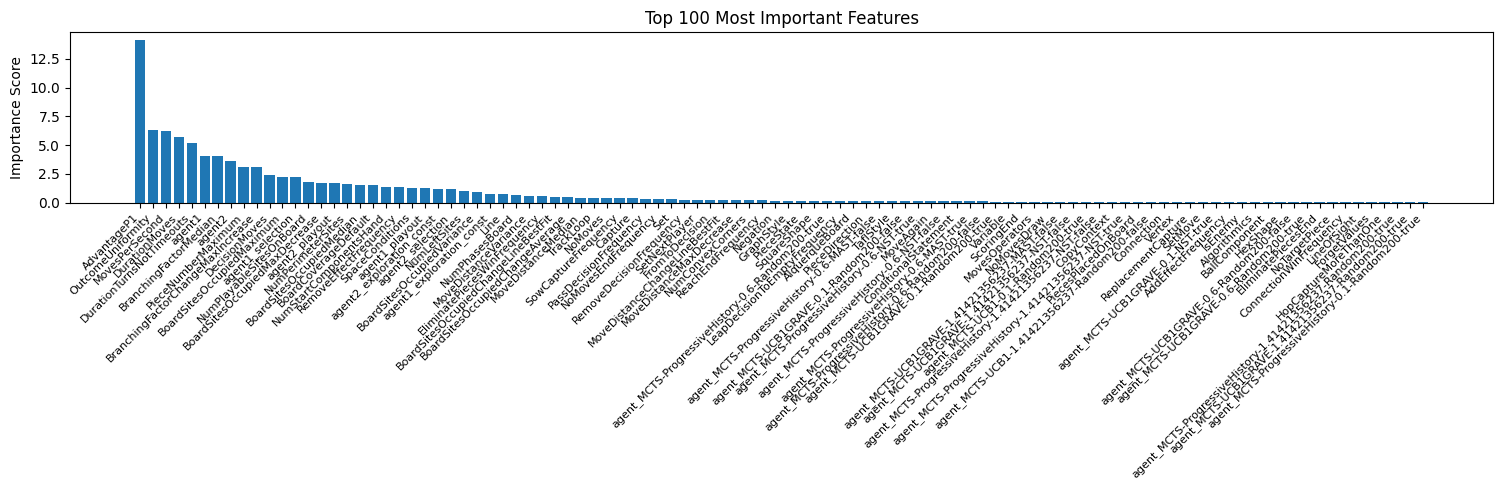

Fold 1 - RMSE: 0.4065657985833874
Fold 2


0:	learn: 0.6143142	test: 0.5378463	best: 0.5378463 (0)	total: 76.5ms	remaining: 3m 49s


50:	learn: 0.3963371	test: 0.4279000	best: 0.4279000 (50)	total: 3.65s	remaining: 3m 31s


100:	learn: 0.3537389	test: 0.4147190	best: 0.4145583 (99)	total: 7.54s	remaining: 3m 36s


150:	learn: 0.3296284	test: 0.4097217	best: 0.4097217 (150)	total: 11.4s	remaining: 3m 35s


200:	learn: 0.3139007	test: 0.4070470	best: 0.4070470 (200)	total: 15.2s	remaining: 3m 31s


250:	learn: 0.3020100	test: 0.4057861	best: 0.4057426 (248)	total: 19s	remaining: 3m 28s


300:	learn: 0.2917453	test: 0.4051696	best: 0.4049018 (290)	total: 22.8s	remaining: 3m 24s


350:	learn: 0.2833274	test: 0.4039133	best: 0.4039133 (350)	total: 26.8s	remaining: 3m 22s


400:	learn: 0.2766030	test: 0.4032314	best: 0.4032314 (400)	total: 30.7s	remaining: 3m 18s


450:	learn: 0.2702244	test: 0.4026266	best: 0.4026266 (450)	total: 34.6s	remaining: 3m 15s


500:	learn: 0.2644284	test: 0.4023311	best: 0.4022395 (496)	total: 38.5s	remaining: 3m 12s


550:	learn: 0.2596055	test: 0.4021547	best: 0.4021457 (549)	total: 42.5s	remaining: 3m 8s


600:	learn: 0.2551050	test: 0.4023544	best: 0.4020787 (566)	total: 46.4s	remaining: 3m 5s


650:	learn: 0.2506210	test: 0.4024268	best: 0.4020787 (566)	total: 50.2s	remaining: 3m 1s


700:	learn: 0.2470099	test: 0.4026282	best: 0.4020787 (566)	total: 54.2s	remaining: 2m 57s


750:	learn: 0.2434268	test: 0.4026549	best: 0.4020787 (566)	total: 58.1s	remaining: 2m 54s


800:	learn: 0.2405506	test: 0.4024890	best: 0.4020787 (566)	total: 1m 2s	remaining: 2m 50s


850:	learn: 0.2372614	test: 0.4023732	best: 0.4020787 (566)	total: 1m 6s	remaining: 2m 46s


900:	learn: 0.2341878	test: 0.4022573	best: 0.4020787 (566)	total: 1m 10s	remaining: 2m 43s


950:	learn: 0.2312622	test: 0.4022175	best: 0.4020787 (566)	total: 1m 13s	remaining: 2m 39s


1000:	learn: 0.2285308	test: 0.4023398	best: 0.4020787 (566)	total: 1m 17s	remaining: 2m 35s


1050:	learn: 0.2260414	test: 0.4022112	best: 0.4020787 (566)	total: 1m 22s	remaining: 2m 32s


1100:	learn: 0.2236570	test: 0.4021647	best: 0.4020787 (566)	total: 1m 25s	remaining: 2m 28s


1150:	learn: 0.2213667	test: 0.4020820	best: 0.4020787 (566)	total: 1m 30s	remaining: 2m 24s


1200:	learn: 0.2192407	test: 0.4020938	best: 0.4020477 (1181)	total: 1m 34s	remaining: 2m 20s


1250:	learn: 0.2170409	test: 0.4019793	best: 0.4019791 (1249)	total: 1m 38s	remaining: 2m 17s


1300:	learn: 0.2149230	test: 0.4019802	best: 0.4018899 (1278)	total: 1m 42s	remaining: 2m 13s


1350:	learn: 0.2130058	test: 0.4019565	best: 0.4018899 (1278)	total: 1m 46s	remaining: 2m 9s


1400:	learn: 0.2109950	test: 0.4019773	best: 0.4018899 (1278)	total: 1m 50s	remaining: 2m 5s


1450:	learn: 0.2091200	test: 0.4020476	best: 0.4018899 (1278)	total: 1m 54s	remaining: 2m 1s


1500:	learn: 0.2072995	test: 0.4021662	best: 0.4018899 (1278)	total: 1m 58s	remaining: 1m 58s


1550:	learn: 0.2054767	test: 0.4020940	best: 0.4018899 (1278)	total: 2m 2s	remaining: 1m 54s


1600:	learn: 0.2036453	test: 0.4019507	best: 0.4018899 (1278)	total: 2m 6s	remaining: 1m 50s


1650:	learn: 0.2019360	test: 0.4018771	best: 0.4018385 (1641)	total: 2m 10s	remaining: 1m 46s


1700:	learn: 0.2002173	test: 0.4017926	best: 0.4017926 (1700)	total: 2m 14s	remaining: 1m 42s


1750:	learn: 0.1986639	test: 0.4018835	best: 0.4017839 (1702)	total: 2m 18s	remaining: 1m 38s


1800:	learn: 0.1970583	test: 0.4018897	best: 0.4017839 (1702)	total: 2m 22s	remaining: 1m 35s


1850:	learn: 0.1955895	test: 0.4019475	best: 0.4017839 (1702)	total: 2m 26s	remaining: 1m 31s


1900:	learn: 0.1940142	test: 0.4019550	best: 0.4017839 (1702)	total: 2m 30s	remaining: 1m 27s


1950:	learn: 0.1925760	test: 0.4020091	best: 0.4017839 (1702)	total: 2m 35s	remaining: 1m 23s


2000:	learn: 0.1910784	test: 0.4020741	best: 0.4017839 (1702)	total: 2m 39s	remaining: 1m 19s


2050:	learn: 0.1896834	test: 0.4021074	best: 0.4017839 (1702)	total: 2m 43s	remaining: 1m 15s


2100:	learn: 0.1883983	test: 0.4021578	best: 0.4017839 (1702)	total: 2m 47s	remaining: 1m 11s


2150:	learn: 0.1871615	test: 0.4021958	best: 0.4017839 (1702)	total: 2m 51s	remaining: 1m 7s


2200:	learn: 0.1856457	test: 0.4022556	best: 0.4017839 (1702)	total: 2m 55s	remaining: 1m 3s


2250:	learn: 0.1842612	test: 0.4022300	best: 0.4017839 (1702)	total: 2m 59s	remaining: 59.9s


2300:	learn: 0.1829206	test: 0.4022690	best: 0.4017839 (1702)	total: 3m 4s	remaining: 55.9s


2350:	learn: 0.1816650	test: 0.4022782	best: 0.4017839 (1702)	total: 3m 8s	remaining: 52s


2400:	learn: 0.1802778	test: 0.4022485	best: 0.4017839 (1702)	total: 3m 12s	remaining: 48s


2450:	learn: 0.1790772	test: 0.4022634	best: 0.4017839 (1702)	total: 3m 16s	remaining: 44s


2500:	learn: 0.1778017	test: 0.4023391	best: 0.4017839 (1702)	total: 3m 20s	remaining: 40s


2550:	learn: 0.1766492	test: 0.4024131	best: 0.4017839 (1702)	total: 3m 24s	remaining: 36s


2600:	learn: 0.1755318	test: 0.4024439	best: 0.4017839 (1702)	total: 3m 28s	remaining: 32.1s


2650:	learn: 0.1743412	test: 0.4025086	best: 0.4017839 (1702)	total: 3m 33s	remaining: 28.1s


2700:	learn: 0.1732296	test: 0.4025542	best: 0.4017839 (1702)	total: 3m 37s	remaining: 24.1s


2750:	learn: 0.1720966	test: 0.4024974	best: 0.4017839 (1702)	total: 3m 41s	remaining: 20.1s


2800:	learn: 0.1709042	test: 0.4025168	best: 0.4017839 (1702)	total: 3m 45s	remaining: 16s


2850:	learn: 0.1697108	test: 0.4025588	best: 0.4017839 (1702)	total: 3m 49s	remaining: 12s


2900:	learn: 0.1687003	test: 0.4026047	best: 0.4017839 (1702)	total: 3m 54s	remaining: 7.99s


2950:	learn: 0.1677430	test: 0.4025771	best: 0.4017839 (1702)	total: 3m 58s	remaining: 3.96s


2999:	learn: 0.1667397	test: 0.4026182	best: 0.4017839 (1702)	total: 4m 2s	remaining: 0us

bestTest = 0.4017838813
bestIteration = 1702

Shrink model to first 1703 iterations.


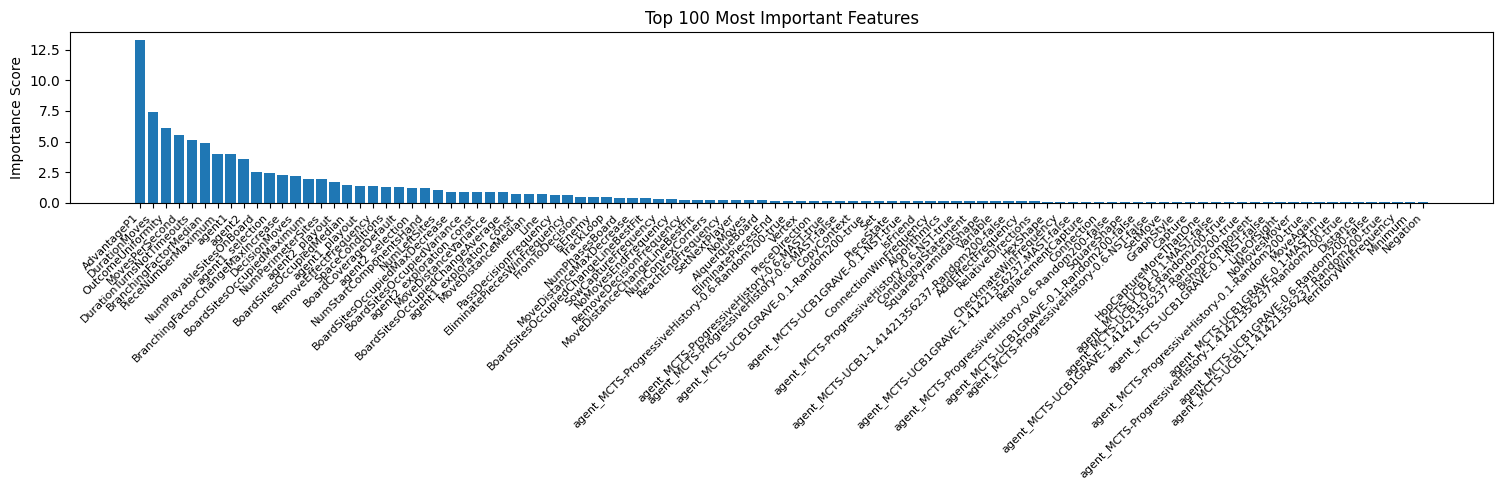

Fold 2 - RMSE: 0.40138502611481097
Fold 3


0:	learn: 0.6014145	test: 0.6076319	best: 0.6076319 (0)	total: 69.9ms	remaining: 3m 29s


50:	learn: 0.3848740	test: 0.4812885	best: 0.4812885 (50)	total: 3.81s	remaining: 3m 40s


100:	learn: 0.3455242	test: 0.4580514	best: 0.4580514 (100)	total: 7.93s	remaining: 3m 47s


150:	learn: 0.3240536	test: 0.4492182	best: 0.4492182 (150)	total: 11.9s	remaining: 3m 45s


200:	learn: 0.3098377	test: 0.4440502	best: 0.4440502 (200)	total: 16.1s	remaining: 3m 43s


250:	learn: 0.2984599	test: 0.4413888	best: 0.4413888 (250)	total: 20.2s	remaining: 3m 41s


300:	learn: 0.2897251	test: 0.4383986	best: 0.4383986 (300)	total: 24.4s	remaining: 3m 38s


350:	learn: 0.2822572	test: 0.4365600	best: 0.4365600 (350)	total: 28.5s	remaining: 3m 35s


400:	learn: 0.2758404	test: 0.4349608	best: 0.4349607 (399)	total: 32.7s	remaining: 3m 31s


450:	learn: 0.2699941	test: 0.4343298	best: 0.4343298 (450)	total: 36.8s	remaining: 3m 27s


500:	learn: 0.2644931	test: 0.4330630	best: 0.4330630 (500)	total: 41s	remaining: 3m 24s


550:	learn: 0.2595467	test: 0.4320583	best: 0.4320517 (549)	total: 45.2s	remaining: 3m 20s


600:	learn: 0.2550972	test: 0.4316578	best: 0.4316578 (600)	total: 49.5s	remaining: 3m 17s


650:	learn: 0.2509624	test: 0.4309539	best: 0.4309283 (648)	total: 53.7s	remaining: 3m 13s


700:	learn: 0.2471678	test: 0.4302779	best: 0.4302740 (699)	total: 57.9s	remaining: 3m 9s


750:	learn: 0.2438324	test: 0.4294773	best: 0.4294773 (750)	total: 1m 2s	remaining: 3m 6s


800:	learn: 0.2406324	test: 0.4287594	best: 0.4287594 (800)	total: 1m 6s	remaining: 3m 1s


850:	learn: 0.2373606	test: 0.4284541	best: 0.4284541 (850)	total: 1m 10s	remaining: 2m 58s


900:	learn: 0.2344943	test: 0.4282249	best: 0.4282249 (900)	total: 1m 14s	remaining: 2m 54s


950:	learn: 0.2315210	test: 0.4279900	best: 0.4279542 (943)	total: 1m 18s	remaining: 2m 50s


1000:	learn: 0.2289104	test: 0.4278028	best: 0.4277751 (997)	total: 1m 23s	remaining: 2m 46s


1050:	learn: 0.2265302	test: 0.4276107	best: 0.4275567 (1032)	total: 1m 27s	remaining: 2m 42s


1100:	learn: 0.2244302	test: 0.4275045	best: 0.4274724 (1086)	total: 1m 31s	remaining: 2m 38s


1150:	learn: 0.2222542	test: 0.4275023	best: 0.4274724 (1086)	total: 1m 36s	remaining: 2m 34s


1200:	learn: 0.2198439	test: 0.4273532	best: 0.4273506 (1199)	total: 1m 40s	remaining: 2m 30s


1250:	learn: 0.2177887	test: 0.4271042	best: 0.4271022 (1244)	total: 1m 44s	remaining: 2m 26s


1300:	learn: 0.2157338	test: 0.4269495	best: 0.4269450 (1299)	total: 1m 48s	remaining: 2m 22s


1350:	learn: 0.2137183	test: 0.4269319	best: 0.4268828 (1338)	total: 1m 53s	remaining: 2m 18s


1400:	learn: 0.2117331	test: 0.4267368	best: 0.4267216 (1386)	total: 1m 57s	remaining: 2m 13s


1450:	learn: 0.2099373	test: 0.4266047	best: 0.4265966 (1444)	total: 2m 1s	remaining: 2m 9s


1500:	learn: 0.2082110	test: 0.4265862	best: 0.4265247 (1471)	total: 2m 5s	remaining: 2m 5s


1550:	learn: 0.2065566	test: 0.4264489	best: 0.4264489 (1550)	total: 2m 10s	remaining: 2m 1s


1600:	learn: 0.2047524	test: 0.4264513	best: 0.4264362 (1590)	total: 2m 14s	remaining: 1m 57s


1650:	learn: 0.2029827	test: 0.4263257	best: 0.4262864 (1634)	total: 2m 18s	remaining: 1m 53s


1700:	learn: 0.2013381	test: 0.4262075	best: 0.4262029 (1698)	total: 2m 22s	remaining: 1m 49s


1750:	learn: 0.1998435	test: 0.4262921	best: 0.4262029 (1698)	total: 2m 27s	remaining: 1m 45s


1800:	learn: 0.1982382	test: 0.4264132	best: 0.4262029 (1698)	total: 2m 31s	remaining: 1m 40s


1850:	learn: 0.1968389	test: 0.4263318	best: 0.4262029 (1698)	total: 2m 35s	remaining: 1m 36s


1900:	learn: 0.1953679	test: 0.4262810	best: 0.4262029 (1698)	total: 2m 40s	remaining: 1m 32s


1950:	learn: 0.1940009	test: 0.4259986	best: 0.4259854 (1947)	total: 2m 44s	remaining: 1m 28s


2000:	learn: 0.1925279	test: 0.4258957	best: 0.4258944 (1999)	total: 2m 48s	remaining: 1m 24s


2050:	learn: 0.1910806	test: 0.4258109	best: 0.4257949 (2043)	total: 2m 52s	remaining: 1m 19s


2100:	learn: 0.1895689	test: 0.4258043	best: 0.4257894 (2078)	total: 2m 57s	remaining: 1m 15s


2150:	learn: 0.1882034	test: 0.4258028	best: 0.4257498 (2124)	total: 3m 1s	remaining: 1m 11s


2200:	learn: 0.1868672	test: 0.4256595	best: 0.4256595 (2200)	total: 3m 5s	remaining: 1m 7s


2250:	learn: 0.1856483	test: 0.4256010	best: 0.4255949 (2244)	total: 3m 9s	remaining: 1m 3s


2300:	learn: 0.1843149	test: 0.4255832	best: 0.4255832 (2300)	total: 3m 14s	remaining: 58.9s


2350:	learn: 0.1831135	test: 0.4256022	best: 0.4255832 (2300)	total: 3m 18s	remaining: 54.7s


2400:	learn: 0.1817870	test: 0.4255882	best: 0.4255620 (2387)	total: 3m 22s	remaining: 50.5s


2450:	learn: 0.1806246	test: 0.4255468	best: 0.4255416 (2448)	total: 3m 26s	remaining: 46.3s


2500:	learn: 0.1794013	test: 0.4255832	best: 0.4255260 (2463)	total: 3m 30s	remaining: 42.1s


2550:	learn: 0.1782163	test: 0.4255445	best: 0.4255260 (2463)	total: 3m 35s	remaining: 37.8s


2600:	learn: 0.1770767	test: 0.4255233	best: 0.4255224 (2558)	total: 3m 39s	remaining: 33.6s


2650:	learn: 0.1758594	test: 0.4254683	best: 0.4254683 (2650)	total: 3m 43s	remaining: 29.4s


2700:	learn: 0.1747645	test: 0.4254046	best: 0.4254035 (2699)	total: 3m 47s	remaining: 25.2s


2750:	learn: 0.1736402	test: 0.4254258	best: 0.4253803 (2713)	total: 3m 51s	remaining: 21s


2800:	learn: 0.1725973	test: 0.4253985	best: 0.4253803 (2713)	total: 3m 56s	remaining: 16.8s


2850:	learn: 0.1714673	test: 0.4253788	best: 0.4253608 (2839)	total: 4m	remaining: 12.6s


2900:	learn: 0.1703434	test: 0.4253336	best: 0.4253306 (2865)	total: 4m 4s	remaining: 8.35s


2950:	learn: 0.1692849	test: 0.4252953	best: 0.4252949 (2949)	total: 4m 8s	remaining: 4.13s


2999:	learn: 0.1682282	test: 0.4252283	best: 0.4252203 (2994)	total: 4m 12s	remaining: 0us

bestTest = 0.4252202785
bestIteration = 2994

Shrink model to first 2995 iterations.


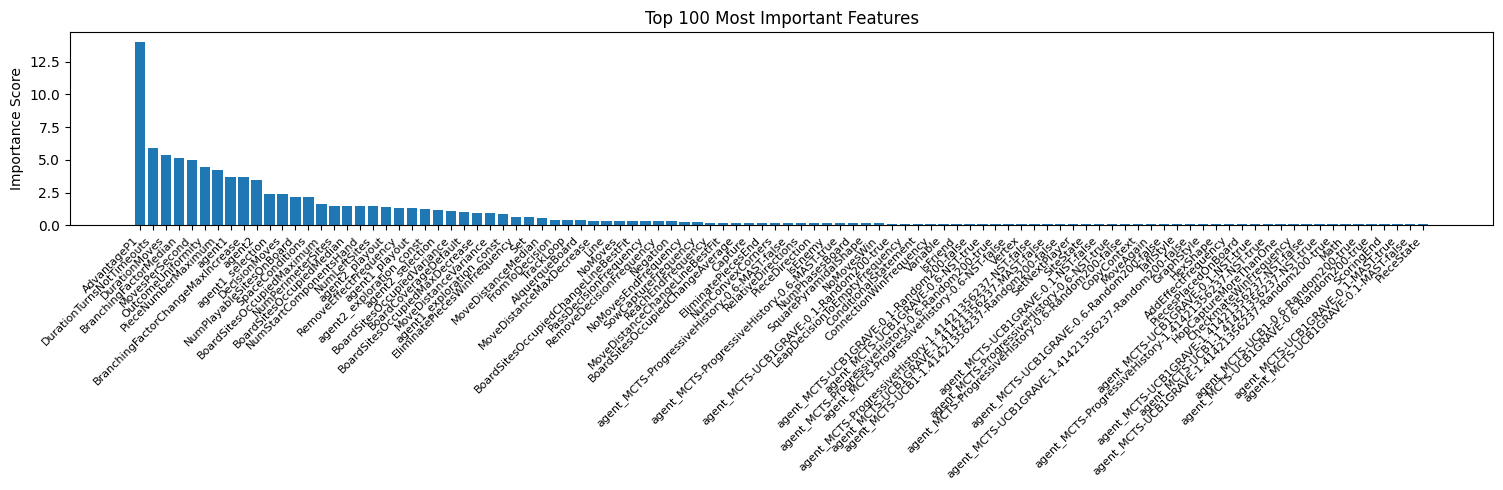

Fold 3 - RMSE: 0.42452436324119563
Fold 4


0:	learn: 0.6044098	test: 0.5945903	best: 0.5945903 (0)	total: 77.4ms	remaining: 3m 51s


50:	learn: 0.3932461	test: 0.4761489	best: 0.4761489 (50)	total: 3.92s	remaining: 3m 46s


100:	learn: 0.3532983	test: 0.4581498	best: 0.4581498 (100)	total: 8.09s	remaining: 3m 52s


150:	learn: 0.3310781	test: 0.4511796	best: 0.4511796 (150)	total: 12.3s	remaining: 3m 51s


200:	learn: 0.3147148	test: 0.4469802	best: 0.4469802 (200)	total: 16.5s	remaining: 3m 49s


250:	learn: 0.3032504	test: 0.4445210	best: 0.4445210 (250)	total: 20.6s	remaining: 3m 45s


300:	learn: 0.2939106	test: 0.4432477	best: 0.4432477 (300)	total: 24.8s	remaining: 3m 42s


350:	learn: 0.2852439	test: 0.4415789	best: 0.4415789 (350)	total: 28.9s	remaining: 3m 38s


400:	learn: 0.2785501	test: 0.4405436	best: 0.4405118 (399)	total: 33.1s	remaining: 3m 34s


450:	learn: 0.2722798	test: 0.4395204	best: 0.4395204 (450)	total: 37.4s	remaining: 3m 31s


500:	learn: 0.2666936	test: 0.4386443	best: 0.4386273 (499)	total: 41.6s	remaining: 3m 27s


550:	learn: 0.2624871	test: 0.4377680	best: 0.4377680 (550)	total: 45.9s	remaining: 3m 24s


600:	learn: 0.2581650	test: 0.4376044	best: 0.4375295 (580)	total: 50.1s	remaining: 3m 20s


650:	learn: 0.2544501	test: 0.4373894	best: 0.4373594 (645)	total: 54.4s	remaining: 3m 16s


700:	learn: 0.2507090	test: 0.4371363	best: 0.4371363 (700)	total: 58.6s	remaining: 3m 12s


750:	learn: 0.2471029	test: 0.4366714	best: 0.4366714 (750)	total: 1m 2s	remaining: 3m 7s


800:	learn: 0.2443084	test: 0.4365423	best: 0.4365283 (795)	total: 1m 7s	remaining: 3m 4s


850:	learn: 0.2414401	test: 0.4364204	best: 0.4364110 (838)	total: 1m 11s	remaining: 3m


900:	learn: 0.2386392	test: 0.4361436	best: 0.4361436 (900)	total: 1m 15s	remaining: 2m 56s


950:	learn: 0.2357319	test: 0.4358383	best: 0.4358383 (950)	total: 1m 19s	remaining: 2m 52s


1000:	learn: 0.2327414	test: 0.4356355	best: 0.4356355 (1000)	total: 1m 24s	remaining: 2m 48s


1050:	learn: 0.2302890	test: 0.4353286	best: 0.4352726 (1036)	total: 1m 28s	remaining: 2m 44s


1100:	learn: 0.2279680	test: 0.4352052	best: 0.4351739 (1089)	total: 1m 32s	remaining: 2m 40s


1150:	learn: 0.2254627	test: 0.4349838	best: 0.4349747 (1149)	total: 1m 37s	remaining: 2m 35s


1200:	learn: 0.2230025	test: 0.4347313	best: 0.4347313 (1200)	total: 1m 41s	remaining: 2m 31s


1250:	learn: 0.2207560	test: 0.4346547	best: 0.4346131 (1247)	total: 1m 45s	remaining: 2m 27s


1300:	learn: 0.2187296	test: 0.4342551	best: 0.4342551 (1300)	total: 1m 49s	remaining: 2m 23s


1350:	learn: 0.2166723	test: 0.4341267	best: 0.4341259 (1348)	total: 1m 54s	remaining: 2m 19s


1400:	learn: 0.2148250	test: 0.4339404	best: 0.4339395 (1399)	total: 1m 58s	remaining: 2m 15s


1450:	learn: 0.2132139	test: 0.4338728	best: 0.4338579 (1442)	total: 2m 2s	remaining: 2m 11s


1500:	learn: 0.2112738	test: 0.4339463	best: 0.4338128 (1466)	total: 2m 7s	remaining: 2m 6s


1550:	learn: 0.2095352	test: 0.4339352	best: 0.4338128 (1466)	total: 2m 11s	remaining: 2m 2s


1600:	learn: 0.2076823	test: 0.4337511	best: 0.4337380 (1589)	total: 2m 15s	remaining: 1m 58s


1650:	learn: 0.2060144	test: 0.4337276	best: 0.4337276 (1650)	total: 2m 19s	remaining: 1m 54s


1700:	learn: 0.2043981	test: 0.4338024	best: 0.4337276 (1650)	total: 2m 24s	remaining: 1m 50s


1750:	learn: 0.2028382	test: 0.4337465	best: 0.4337254 (1713)	total: 2m 28s	remaining: 1m 45s


1800:	learn: 0.2012667	test: 0.4337272	best: 0.4337066 (1798)	total: 2m 32s	remaining: 1m 41s


1850:	learn: 0.1996689	test: 0.4337273	best: 0.4337066 (1798)	total: 2m 36s	remaining: 1m 37s


1900:	learn: 0.1980530	test: 0.4337726	best: 0.4337066 (1798)	total: 2m 41s	remaining: 1m 33s


1950:	learn: 0.1965691	test: 0.4337090	best: 0.4337066 (1798)	total: 2m 45s	remaining: 1m 28s


2000:	learn: 0.1951527	test: 0.4336379	best: 0.4336177 (1985)	total: 2m 49s	remaining: 1m 24s


2050:	learn: 0.1936489	test: 0.4336548	best: 0.4335856 (2035)	total: 2m 53s	remaining: 1m 20s


2100:	learn: 0.1923493	test: 0.4335708	best: 0.4335551 (2090)	total: 2m 58s	remaining: 1m 16s


2150:	learn: 0.1908814	test: 0.4335130	best: 0.4335130 (2150)	total: 3m 2s	remaining: 1m 12s


2200:	learn: 0.1895097	test: 0.4335176	best: 0.4334715 (2159)	total: 3m 6s	remaining: 1m 7s


2250:	learn: 0.1881590	test: 0.4334694	best: 0.4334611 (2249)	total: 3m 10s	remaining: 1m 3s


2300:	learn: 0.1869290	test: 0.4334516	best: 0.4334474 (2298)	total: 3m 15s	remaining: 59.3s


2350:	learn: 0.1857118	test: 0.4334903	best: 0.4334248 (2321)	total: 3m 19s	remaining: 55.1s


2400:	learn: 0.1843990	test: 0.4334926	best: 0.4334248 (2321)	total: 3m 23s	remaining: 50.9s


2450:	learn: 0.1831723	test: 0.4334676	best: 0.4334248 (2321)	total: 3m 28s	remaining: 46.6s


2500:	learn: 0.1819367	test: 0.4334833	best: 0.4334248 (2321)	total: 3m 32s	remaining: 42.4s


2550:	learn: 0.1807169	test: 0.4335803	best: 0.4334248 (2321)	total: 3m 36s	remaining: 38.2s


2600:	learn: 0.1795449	test: 0.4336154	best: 0.4334248 (2321)	total: 3m 41s	remaining: 33.9s


2650:	learn: 0.1784680	test: 0.4337263	best: 0.4334248 (2321)	total: 3m 45s	remaining: 29.7s


2700:	learn: 0.1773150	test: 0.4338417	best: 0.4334248 (2321)	total: 3m 49s	remaining: 25.4s


2750:	learn: 0.1762356	test: 0.4338439	best: 0.4334248 (2321)	total: 3m 53s	remaining: 21.2s


2800:	learn: 0.1751323	test: 0.4338095	best: 0.4334248 (2321)	total: 3m 58s	remaining: 16.9s


2850:	learn: 0.1740343	test: 0.4338045	best: 0.4334248 (2321)	total: 4m 2s	remaining: 12.7s


2900:	learn: 0.1729045	test: 0.4338186	best: 0.4334248 (2321)	total: 4m 6s	remaining: 8.42s


2950:	learn: 0.1718212	test: 0.4337675	best: 0.4334248 (2321)	total: 4m 11s	remaining: 4.17s


2999:	learn: 0.1708577	test: 0.4337702	best: 0.4334248 (2321)	total: 4m 15s	remaining: 0us

bestTest = 0.4334248465
bestIteration = 2321

Shrink model to first 2322 iterations.


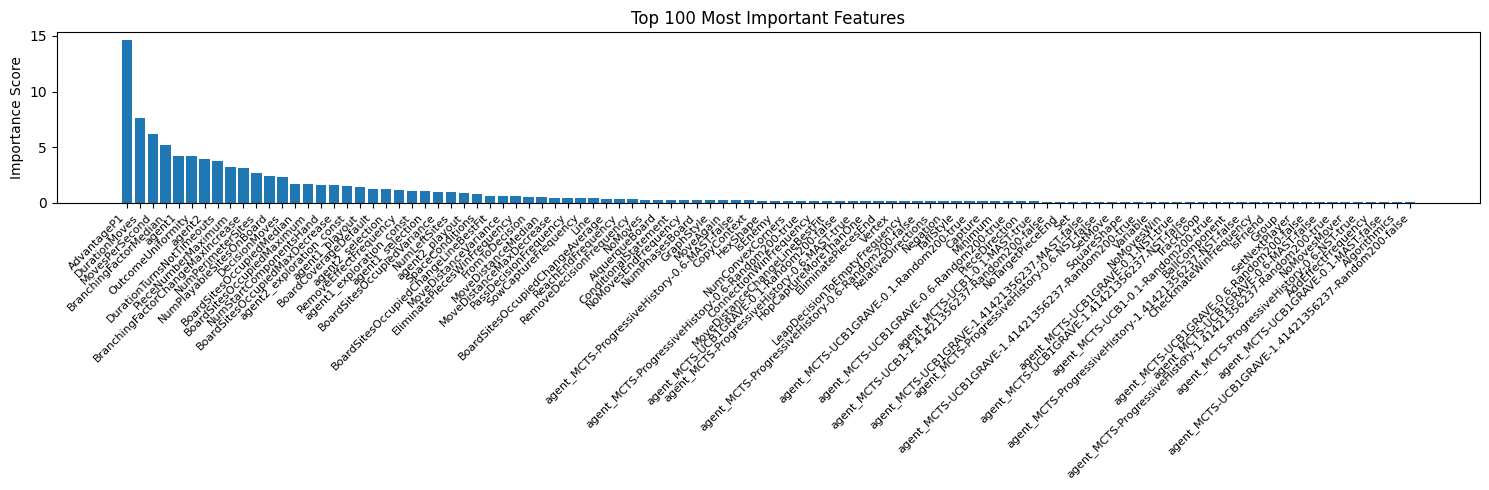

Fold 4 - RMSE: 0.43270405422719244
Fold 5


0:	learn: 0.6049953	test: 0.5871870	best: 0.5871870 (0)	total: 61.8ms	remaining: 3m 5s


50:	learn: 0.3911923	test: 0.4723657	best: 0.4723657 (50)	total: 3.93s	remaining: 3m 47s


100:	learn: 0.3536052	test: 0.4534890	best: 0.4534890 (100)	total: 8.19s	remaining: 3m 55s


150:	learn: 0.3326317	test: 0.4440792	best: 0.4440792 (150)	total: 12.4s	remaining: 3m 54s


200:	learn: 0.3165237	test: 0.4387669	best: 0.4387669 (200)	total: 16.5s	remaining: 3m 50s


250:	learn: 0.3048442	test: 0.4354755	best: 0.4354254 (246)	total: 20.7s	remaining: 3m 47s


300:	learn: 0.2952464	test: 0.4321559	best: 0.4320542 (296)	total: 24.9s	remaining: 3m 42s


350:	learn: 0.2871114	test: 0.4305144	best: 0.4305144 (350)	total: 29.1s	remaining: 3m 39s


400:	learn: 0.2796587	test: 0.4293289	best: 0.4293282 (398)	total: 33.3s	remaining: 3m 35s


450:	learn: 0.2733177	test: 0.4285164	best: 0.4284868 (447)	total: 37.5s	remaining: 3m 31s


500:	learn: 0.2678283	test: 0.4277902	best: 0.4277902 (500)	total: 41.8s	remaining: 3m 28s


550:	learn: 0.2629597	test: 0.4273246	best: 0.4272624 (543)	total: 46s	remaining: 3m 24s


600:	learn: 0.2584647	test: 0.4263813	best: 0.4263813 (600)	total: 50.3s	remaining: 3m 20s


650:	learn: 0.2542190	test: 0.4258567	best: 0.4258552 (638)	total: 54.6s	remaining: 3m 16s


700:	learn: 0.2504088	test: 0.4255956	best: 0.4255956 (700)	total: 58.9s	remaining: 3m 13s


750:	learn: 0.2467671	test: 0.4250368	best: 0.4250368 (750)	total: 1m 3s	remaining: 3m 9s


800:	learn: 0.2434782	test: 0.4245111	best: 0.4245111 (800)	total: 1m 7s	remaining: 3m 5s


850:	learn: 0.2403880	test: 0.4242805	best: 0.4242803 (845)	total: 1m 11s	remaining: 3m 1s


900:	learn: 0.2373587	test: 0.4240445	best: 0.4240442 (895)	total: 1m 16s	remaining: 2m 57s


950:	learn: 0.2344009	test: 0.4239551	best: 0.4239005 (943)	total: 1m 20s	remaining: 2m 53s


1000:	learn: 0.2319110	test: 0.4237330	best: 0.4237005 (996)	total: 1m 24s	remaining: 2m 49s


1050:	learn: 0.2292736	test: 0.4234859	best: 0.4234736 (1047)	total: 1m 28s	remaining: 2m 45s


1100:	learn: 0.2269510	test: 0.4233327	best: 0.4233260 (1099)	total: 1m 33s	remaining: 2m 40s


1150:	learn: 0.2246964	test: 0.4231345	best: 0.4231062 (1140)	total: 1m 37s	remaining: 2m 36s


1200:	learn: 0.2227539	test: 0.4228211	best: 0.4228211 (1200)	total: 1m 41s	remaining: 2m 32s


1250:	learn: 0.2206194	test: 0.4227369	best: 0.4226984 (1237)	total: 1m 46s	remaining: 2m 28s


1300:	learn: 0.2184628	test: 0.4226349	best: 0.4226349 (1300)	total: 1m 50s	remaining: 2m 24s


1350:	learn: 0.2165661	test: 0.4225399	best: 0.4225335 (1348)	total: 1m 54s	remaining: 2m 19s


1400:	learn: 0.2148120	test: 0.4225545	best: 0.4225074 (1388)	total: 1m 59s	remaining: 2m 15s


1450:	learn: 0.2127164	test: 0.4223572	best: 0.4223570 (1443)	total: 2m 3s	remaining: 2m 11s


1500:	learn: 0.2110050	test: 0.4221838	best: 0.4221819 (1495)	total: 2m 7s	remaining: 2m 7s


1550:	learn: 0.2091445	test: 0.4221280	best: 0.4221121 (1548)	total: 2m 11s	remaining: 2m 3s


1600:	learn: 0.2072916	test: 0.4219311	best: 0.4219088 (1597)	total: 2m 16s	remaining: 1m 58s


1650:	learn: 0.2055779	test: 0.4217902	best: 0.4217902 (1650)	total: 2m 20s	remaining: 1m 54s


1700:	learn: 0.2039079	test: 0.4217487	best: 0.4217438 (1693)	total: 2m 24s	remaining: 1m 50s


1750:	learn: 0.2023516	test: 0.4216239	best: 0.4216168 (1747)	total: 2m 28s	remaining: 1m 46s


1800:	learn: 0.2007491	test: 0.4216323	best: 0.4216168 (1747)	total: 2m 33s	remaining: 1m 41s


1850:	learn: 0.1990772	test: 0.4215631	best: 0.4215554 (1834)	total: 2m 37s	remaining: 1m 37s


1900:	learn: 0.1975360	test: 0.4215155	best: 0.4215155 (1900)	total: 2m 41s	remaining: 1m 33s


1950:	learn: 0.1960563	test: 0.4215843	best: 0.4215068 (1908)	total: 2m 46s	remaining: 1m 29s


2000:	learn: 0.1946396	test: 0.4214004	best: 0.4214004 (2000)	total: 2m 50s	remaining: 1m 25s


2050:	learn: 0.1931839	test: 0.4214227	best: 0.4213841 (2047)	total: 2m 54s	remaining: 1m 20s


2100:	learn: 0.1918300	test: 0.4212699	best: 0.4212661 (2099)	total: 2m 59s	remaining: 1m 16s


2150:	learn: 0.1903775	test: 0.4212733	best: 0.4212553 (2141)	total: 3m 3s	remaining: 1m 12s


2200:	learn: 0.1889463	test: 0.4211974	best: 0.4211849 (2198)	total: 3m 7s	remaining: 1m 8s


2250:	learn: 0.1876759	test: 0.4211673	best: 0.4211447 (2248)	total: 3m 11s	remaining: 1m 3s


2300:	learn: 0.1864073	test: 0.4211030	best: 0.4210985 (2299)	total: 3m 16s	remaining: 59.6s


2350:	learn: 0.1850580	test: 0.4210412	best: 0.4210128 (2323)	total: 3m 20s	remaining: 55.3s


2400:	learn: 0.1837250	test: 0.4210510	best: 0.4210128 (2323)	total: 3m 24s	remaining: 51.1s


2450:	learn: 0.1824600	test: 0.4210657	best: 0.4210128 (2323)	total: 3m 29s	remaining: 46.8s


2500:	learn: 0.1812112	test: 0.4211492	best: 0.4210128 (2323)	total: 3m 33s	remaining: 42.6s


2550:	learn: 0.1799961	test: 0.4211120	best: 0.4210128 (2323)	total: 3m 37s	remaining: 38.3s


2600:	learn: 0.1787924	test: 0.4211112	best: 0.4210128 (2323)	total: 3m 41s	remaining: 34s


2650:	learn: 0.1776966	test: 0.4211220	best: 0.4210128 (2323)	total: 3m 46s	remaining: 29.8s


2700:	learn: 0.1766247	test: 0.4210959	best: 0.4210128 (2323)	total: 3m 50s	remaining: 25.5s


2750:	learn: 0.1755160	test: 0.4211431	best: 0.4210128 (2323)	total: 3m 54s	remaining: 21.2s


2800:	learn: 0.1744082	test: 0.4210955	best: 0.4210128 (2323)	total: 3m 59s	remaining: 17s


2850:	learn: 0.1734031	test: 0.4210765	best: 0.4210128 (2323)	total: 4m 3s	remaining: 12.7s


2900:	learn: 0.1722881	test: 0.4210647	best: 0.4210128 (2323)	total: 4m 7s	remaining: 8.45s


2950:	learn: 0.1712437	test: 0.4210858	best: 0.4210128 (2323)	total: 4m 11s	remaining: 4.18s


2999:	learn: 0.1701149	test: 0.4211032	best: 0.4210128 (2323)	total: 4m 16s	remaining: 0us

bestTest = 0.4210127807
bestIteration = 2323

Shrink model to first 2324 iterations.


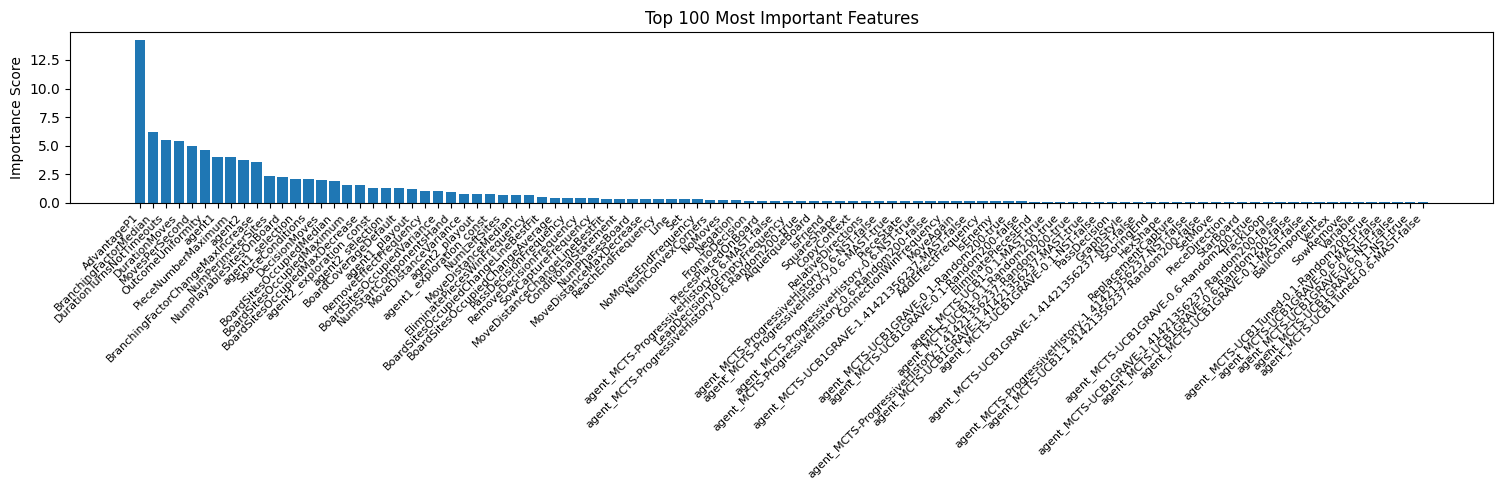

Fold 5 - RMSE: 0.42031117369698623
List of oof scores: [0.4065657985833874, 0.40138502611481097, 0.42452436324119563, 0.43270405422719244, 0.42031117369698623]
Average oof score: 0.4170980831727146


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6094546	test: 0.5681171	best: 0.5681171 (0)	total: 62.8ms	remaining: 3m 8s


50:	learn: 0.3907446	test: 0.4650489	best: 0.4650489 (50)	total: 3.92s	remaining: 3m 46s


100:	learn: 0.3512932	test: 0.4485359	best: 0.4485359 (100)	total: 8.2s	remaining: 3m 55s


150:	learn: 0.3277186	test: 0.4408743	best: 0.4408743 (150)	total: 12.3s	remaining: 3m 51s


200:	learn: 0.3122973	test: 0.4367735	best: 0.4367735 (200)	total: 16.4s	remaining: 3m 48s


250:	learn: 0.3010170	test: 0.4343726	best: 0.4343726 (250)	total: 20.7s	remaining: 3m 46s


300:	learn: 0.2913413	test: 0.4327910	best: 0.4327910 (300)	total: 24.9s	remaining: 3m 43s


350:	learn: 0.2832796	test: 0.4322342	best: 0.4322342 (350)	total: 29.1s	remaining: 3m 39s


400:	learn: 0.2763138	test: 0.4310473	best: 0.4309888 (398)	total: 33.4s	remaining: 3m 36s


450:	learn: 0.2698724	test: 0.4305340	best: 0.4305340 (450)	total: 37.6s	remaining: 3m 32s


500:	learn: 0.2644204	test: 0.4299768	best: 0.4299768 (500)	total: 41.9s	remaining: 3m 29s


550:	learn: 0.2592324	test: 0.4294731	best: 0.4294640 (549)	total: 46.2s	remaining: 3m 25s


600:	learn: 0.2547589	test: 0.4291459	best: 0.4290957 (593)	total: 50.5s	remaining: 3m 21s


650:	learn: 0.2504009	test: 0.4292040	best: 0.4290957 (593)	total: 54.7s	remaining: 3m 17s


700:	learn: 0.2470433	test: 0.4290746	best: 0.4290509 (693)	total: 59s	remaining: 3m 13s


750:	learn: 0.2436732	test: 0.4289312	best: 0.4289035 (749)	total: 1m 3s	remaining: 3m 9s


800:	learn: 0.2404474	test: 0.4286269	best: 0.4286269 (800)	total: 1m 7s	remaining: 3m 5s


850:	learn: 0.2373749	test: 0.4285046	best: 0.4285046 (850)	total: 1m 11s	remaining: 3m 1s


900:	learn: 0.2346340	test: 0.4283360	best: 0.4282876 (889)	total: 1m 16s	remaining: 2m 57s


950:	learn: 0.2319797	test: 0.4278800	best: 0.4278589 (945)	total: 1m 20s	remaining: 2m 53s


1000:	learn: 0.2296774	test: 0.4277147	best: 0.4277147 (1000)	total: 1m 24s	remaining: 2m 49s


1050:	learn: 0.2273131	test: 0.4274986	best: 0.4274950 (1049)	total: 1m 29s	remaining: 2m 45s


1100:	learn: 0.2250547	test: 0.4273689	best: 0.4272734 (1075)	total: 1m 33s	remaining: 2m 41s


1150:	learn: 0.2229030	test: 0.4271520	best: 0.4271468 (1149)	total: 1m 37s	remaining: 2m 36s


1200:	learn: 0.2206196	test: 0.4272103	best: 0.4271021 (1179)	total: 1m 42s	remaining: 2m 32s


1250:	learn: 0.2185037	test: 0.4270917	best: 0.4270725 (1229)	total: 1m 46s	remaining: 2m 28s


1300:	learn: 0.2164497	test: 0.4269789	best: 0.4269746 (1296)	total: 1m 50s	remaining: 2m 24s


1350:	learn: 0.2146424	test: 0.4268897	best: 0.4268674 (1332)	total: 1m 54s	remaining: 2m 20s


1400:	learn: 0.2126799	test: 0.4267800	best: 0.4267710 (1397)	total: 1m 59s	remaining: 2m 16s


1450:	learn: 0.2107857	test: 0.4267740	best: 0.4267330 (1416)	total: 2m 3s	remaining: 2m 11s


1500:	learn: 0.2088358	test: 0.4266889	best: 0.4266786 (1498)	total: 2m 7s	remaining: 2m 7s


1550:	learn: 0.2070804	test: 0.4266874	best: 0.4266538 (1519)	total: 2m 12s	remaining: 2m 3s


1600:	learn: 0.2053201	test: 0.4266039	best: 0.4265933 (1581)	total: 2m 16s	remaining: 1m 59s


1650:	learn: 0.2034646	test: 0.4264927	best: 0.4264869 (1638)	total: 2m 20s	remaining: 1m 54s


1700:	learn: 0.2019551	test: 0.4264030	best: 0.4263799 (1697)	total: 2m 25s	remaining: 1m 50s


1750:	learn: 0.2003848	test: 0.4262707	best: 0.4262707 (1750)	total: 2m 29s	remaining: 1m 46s


1800:	learn: 0.1989312	test: 0.4263654	best: 0.4262241 (1759)	total: 2m 33s	remaining: 1m 42s


1850:	learn: 0.1975785	test: 0.4263651	best: 0.4262241 (1759)	total: 2m 38s	remaining: 1m 38s


1900:	learn: 0.1961506	test: 0.4263788	best: 0.4262241 (1759)	total: 2m 42s	remaining: 1m 33s


1950:	learn: 0.1946803	test: 0.4262847	best: 0.4262241 (1759)	total: 2m 46s	remaining: 1m 29s


2000:	learn: 0.1933192	test: 0.4262207	best: 0.4262164 (1999)	total: 2m 51s	remaining: 1m 25s


2050:	learn: 0.1919492	test: 0.4262298	best: 0.4262052 (2003)	total: 2m 55s	remaining: 1m 21s


2100:	learn: 0.1905779	test: 0.4261804	best: 0.4261804 (2100)	total: 2m 59s	remaining: 1m 16s


2150:	learn: 0.1892069	test: 0.4261240	best: 0.4261123 (2134)	total: 3m 3s	remaining: 1m 12s


2200:	learn: 0.1878942	test: 0.4260353	best: 0.4260116 (2182)	total: 3m 8s	remaining: 1m 8s


2250:	learn: 0.1867270	test: 0.4259997	best: 0.4259958 (2246)	total: 3m 12s	remaining: 1m 4s


2300:	learn: 0.1855288	test: 0.4260526	best: 0.4259958 (2246)	total: 3m 16s	remaining: 59.8s


2350:	learn: 0.1842226	test: 0.4260621	best: 0.4259958 (2246)	total: 3m 21s	remaining: 55.5s


2400:	learn: 0.1830027	test: 0.4260288	best: 0.4259958 (2246)	total: 3m 25s	remaining: 51.3s


2450:	learn: 0.1817799	test: 0.4259535	best: 0.4259409 (2447)	total: 3m 29s	remaining: 47s


2500:	learn: 0.1806369	test: 0.4259070	best: 0.4258981 (2495)	total: 3m 34s	remaining: 42.7s


2550:	learn: 0.1795979	test: 0.4259581	best: 0.4258944 (2511)	total: 3m 38s	remaining: 38.5s


2600:	learn: 0.1783631	test: 0.4259703	best: 0.4258944 (2511)	total: 3m 42s	remaining: 34.2s


2650:	learn: 0.1772650	test: 0.4259944	best: 0.4258944 (2511)	total: 3m 47s	remaining: 29.9s


2700:	learn: 0.1762985	test: 0.4260352	best: 0.4258944 (2511)	total: 3m 51s	remaining: 25.6s


2750:	learn: 0.1753192	test: 0.4260003	best: 0.4258944 (2511)	total: 3m 55s	remaining: 21.4s


2800:	learn: 0.1742258	test: 0.4259764	best: 0.4258944 (2511)	total: 4m	remaining: 17.1s


2850:	learn: 0.1731937	test: 0.4259610	best: 0.4258944 (2511)	total: 4m 4s	remaining: 12.8s


2900:	learn: 0.1721543	test: 0.4259731	best: 0.4258944 (2511)	total: 4m 8s	remaining: 8.49s


2950:	learn: 0.1710971	test: 0.4259307	best: 0.4258944 (2511)	total: 4m 13s	remaining: 4.2s


2999:	learn: 0.1701182	test: 0.4259570	best: 0.4258944 (2511)	total: 4m 17s	remaining: 0us

bestTest = 0.425894397
bestIteration = 2511

Shrink model to first 2512 iterations.


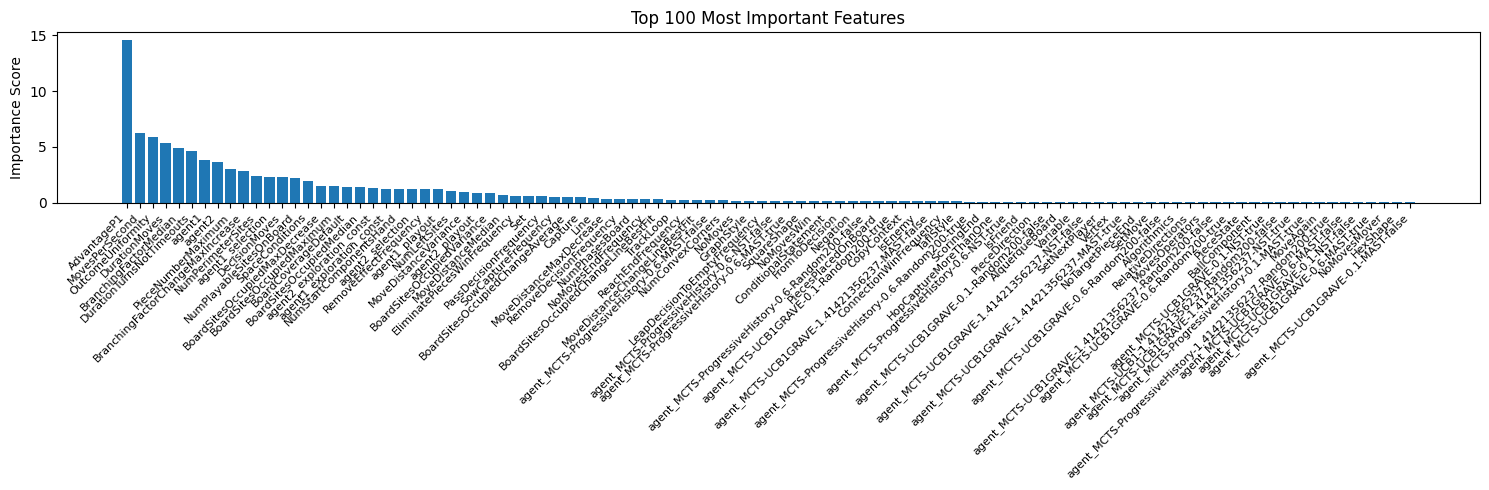

Fold 1 - RMSE: 0.42540093045396526
Fold 2


0:	learn: 0.6094233	test: 0.5684644	best: 0.5684644 (0)	total: 72.1ms	remaining: 3m 36s


50:	learn: 0.3904241	test: 0.4619684	best: 0.4619684 (50)	total: 3.96s	remaining: 3m 48s


100:	learn: 0.3536767	test: 0.4442743	best: 0.4442743 (100)	total: 8.26s	remaining: 3m 57s


150:	learn: 0.3306533	test: 0.4363053	best: 0.4362931 (146)	total: 12.3s	remaining: 3m 52s


200:	learn: 0.3135338	test: 0.4312591	best: 0.4312591 (200)	total: 16.5s	remaining: 3m 50s


250:	learn: 0.3016736	test: 0.4289156	best: 0.4289047 (249)	total: 20.8s	remaining: 3m 47s


300:	learn: 0.2930004	test: 0.4274729	best: 0.4273890 (299)	total: 25.1s	remaining: 3m 44s


350:	learn: 0.2854324	test: 0.4258257	best: 0.4258163 (346)	total: 29.3s	remaining: 3m 41s


400:	learn: 0.2784279	test: 0.4248568	best: 0.4247946 (396)	total: 33.6s	remaining: 3m 37s


450:	learn: 0.2724053	test: 0.4237515	best: 0.4237515 (450)	total: 37.9s	remaining: 3m 34s


500:	learn: 0.2667466	test: 0.4228335	best: 0.4227758 (494)	total: 42.1s	remaining: 3m 30s


550:	learn: 0.2620274	test: 0.4225286	best: 0.4225168 (537)	total: 46.4s	remaining: 3m 26s


600:	learn: 0.2574426	test: 0.4218635	best: 0.4218313 (597)	total: 50.7s	remaining: 3m 22s


650:	learn: 0.2530091	test: 0.4214698	best: 0.4213922 (625)	total: 55s	remaining: 3m 18s


700:	learn: 0.2494063	test: 0.4211031	best: 0.4210131 (699)	total: 59.2s	remaining: 3m 14s


750:	learn: 0.2460568	test: 0.4206415	best: 0.4206292 (749)	total: 1m 3s	remaining: 3m 10s


800:	learn: 0.2431959	test: 0.4203154	best: 0.4202836 (798)	total: 1m 7s	remaining: 3m 6s


850:	learn: 0.2398891	test: 0.4199144	best: 0.4199144 (850)	total: 1m 12s	remaining: 3m 2s


900:	learn: 0.2368218	test: 0.4196995	best: 0.4196995 (900)	total: 1m 16s	remaining: 2m 58s


950:	learn: 0.2341024	test: 0.4194854	best: 0.4194143 (940)	total: 1m 20s	remaining: 2m 54s


1000:	learn: 0.2314711	test: 0.4192284	best: 0.4192008 (987)	total: 1m 25s	remaining: 2m 49s


1050:	learn: 0.2289976	test: 0.4191250	best: 0.4191248 (1048)	total: 1m 29s	remaining: 2m 45s


1100:	learn: 0.2266549	test: 0.4189245	best: 0.4189046 (1097)	total: 1m 33s	remaining: 2m 41s


1150:	learn: 0.2244882	test: 0.4188616	best: 0.4188338 (1121)	total: 1m 38s	remaining: 2m 37s


1200:	learn: 0.2225122	test: 0.4186176	best: 0.4186090 (1197)	total: 1m 42s	remaining: 2m 33s


1250:	learn: 0.2202999	test: 0.4185609	best: 0.4185576 (1247)	total: 1m 46s	remaining: 2m 29s


1300:	learn: 0.2182484	test: 0.4182916	best: 0.4182807 (1288)	total: 1m 51s	remaining: 2m 24s


1350:	learn: 0.2162916	test: 0.4182358	best: 0.4182162 (1345)	total: 1m 55s	remaining: 2m 20s


1400:	learn: 0.2143770	test: 0.4181307	best: 0.4181205 (1399)	total: 1m 59s	remaining: 2m 16s


1450:	learn: 0.2125109	test: 0.4181102	best: 0.4180494 (1418)	total: 2m 3s	remaining: 2m 12s


1500:	learn: 0.2106876	test: 0.4180686	best: 0.4180184 (1467)	total: 2m 8s	remaining: 2m 8s


1550:	learn: 0.2087956	test: 0.4180011	best: 0.4179917 (1530)	total: 2m 12s	remaining: 2m 3s


1600:	learn: 0.2071399	test: 0.4179655	best: 0.4179093 (1566)	total: 2m 17s	remaining: 1m 59s


1650:	learn: 0.2054702	test: 0.4178408	best: 0.4178292 (1647)	total: 2m 21s	remaining: 1m 55s


1700:	learn: 0.2037933	test: 0.4176526	best: 0.4176514 (1699)	total: 2m 25s	remaining: 1m 51s


1750:	learn: 0.2022272	test: 0.4176069	best: 0.4176052 (1747)	total: 2m 30s	remaining: 1m 47s


1800:	learn: 0.2006445	test: 0.4175671	best: 0.4175671 (1800)	total: 2m 34s	remaining: 1m 42s


1850:	learn: 0.1990622	test: 0.4175362	best: 0.4175362 (1850)	total: 2m 38s	remaining: 1m 38s


1900:	learn: 0.1977243	test: 0.4175254	best: 0.4174169 (1871)	total: 2m 43s	remaining: 1m 34s


1950:	learn: 0.1962202	test: 0.4175032	best: 0.4174169 (1871)	total: 2m 47s	remaining: 1m 29s


2000:	learn: 0.1947959	test: 0.4174938	best: 0.4174169 (1871)	total: 2m 51s	remaining: 1m 25s


2050:	learn: 0.1933759	test: 0.4174836	best: 0.4174169 (1871)	total: 2m 55s	remaining: 1m 21s


2100:	learn: 0.1919857	test: 0.4173420	best: 0.4173027 (2087)	total: 3m	remaining: 1m 17s


2150:	learn: 0.1906315	test: 0.4173007	best: 0.4172929 (2147)	total: 3m 4s	remaining: 1m 12s


2200:	learn: 0.1892071	test: 0.4172568	best: 0.4172432 (2185)	total: 3m 8s	remaining: 1m 8s


2250:	learn: 0.1878557	test: 0.4172573	best: 0.4171943 (2229)	total: 3m 12s	remaining: 1m 4s


2300:	learn: 0.1864738	test: 0.4172415	best: 0.4171943 (2229)	total: 3m 17s	remaining: 59.9s


2350:	learn: 0.1851542	test: 0.4173126	best: 0.4171943 (2229)	total: 3m 21s	remaining: 55.7s


2400:	learn: 0.1839512	test: 0.4172748	best: 0.4171943 (2229)	total: 3m 25s	remaining: 51.4s


2450:	learn: 0.1827307	test: 0.4172945	best: 0.4171943 (2229)	total: 3m 30s	remaining: 47.1s


2500:	learn: 0.1816642	test: 0.4173928	best: 0.4171943 (2229)	total: 3m 34s	remaining: 42.8s


2550:	learn: 0.1805574	test: 0.4174310	best: 0.4171943 (2229)	total: 3m 38s	remaining: 38.5s


2600:	learn: 0.1794360	test: 0.4174426	best: 0.4171943 (2229)	total: 3m 43s	remaining: 34.2s


2650:	learn: 0.1782130	test: 0.4174922	best: 0.4171943 (2229)	total: 3m 47s	remaining: 29.9s


2700:	learn: 0.1770985	test: 0.4174928	best: 0.4171943 (2229)	total: 3m 51s	remaining: 25.7s


2750:	learn: 0.1759203	test: 0.4175003	best: 0.4171943 (2229)	total: 3m 56s	remaining: 21.4s


2800:	learn: 0.1748908	test: 0.4174679	best: 0.4171943 (2229)	total: 4m	remaining: 17.1s


2850:	learn: 0.1738542	test: 0.4174463	best: 0.4171943 (2229)	total: 4m 4s	remaining: 12.8s


2900:	learn: 0.1728750	test: 0.4174297	best: 0.4171943 (2229)	total: 4m 9s	remaining: 8.51s


2950:	learn: 0.1717616	test: 0.4173538	best: 0.4171943 (2229)	total: 4m 13s	remaining: 4.21s


2999:	learn: 0.1708207	test: 0.4173189	best: 0.4171943 (2229)	total: 4m 17s	remaining: 0us

bestTest = 0.4171943353
bestIteration = 2229

Shrink model to first 2230 iterations.


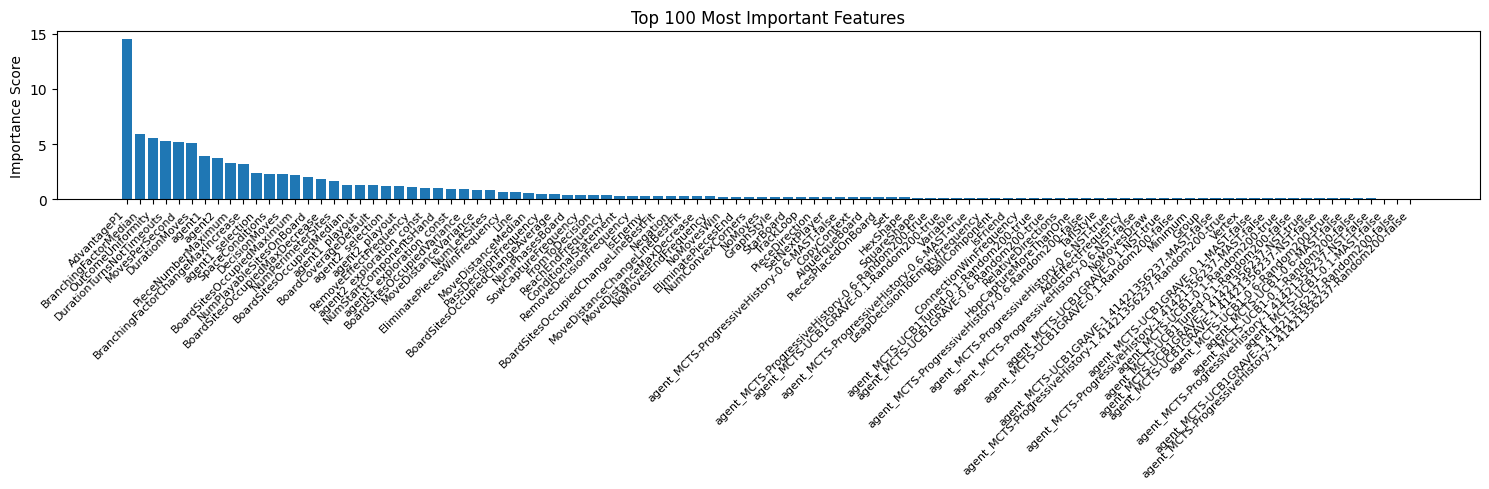

Fold 2 - RMSE: 0.41667572179083207
Fold 3


0:	learn: 0.6118799	test: 0.5677827	best: 0.5677827 (0)	total: 69.1ms	remaining: 3m 27s


50:	learn: 0.3904339	test: 0.4662049	best: 0.4662049 (50)	total: 3.86s	remaining: 3m 42s


100:	learn: 0.3507936	test: 0.4520090	best: 0.4519983 (98)	total: 7.94s	remaining: 3m 47s


150:	learn: 0.3272088	test: 0.4441055	best: 0.4441055 (150)	total: 12s	remaining: 3m 46s


200:	learn: 0.3119223	test: 0.4405038	best: 0.4403486 (198)	total: 16.1s	remaining: 3m 44s


250:	learn: 0.3007201	test: 0.4383568	best: 0.4383508 (249)	total: 20.3s	remaining: 3m 42s


300:	learn: 0.2920738	test: 0.4362670	best: 0.4362399 (299)	total: 24.5s	remaining: 3m 39s


350:	learn: 0.2844340	test: 0.4350901	best: 0.4350901 (350)	total: 28.7s	remaining: 3m 36s


400:	learn: 0.2775280	test: 0.4344821	best: 0.4344746 (397)	total: 32.8s	remaining: 3m 32s


450:	learn: 0.2718121	test: 0.4337302	best: 0.4337268 (449)	total: 37s	remaining: 3m 29s


500:	learn: 0.2660947	test: 0.4326093	best: 0.4326093 (500)	total: 41.1s	remaining: 3m 25s


550:	learn: 0.2610726	test: 0.4321033	best: 0.4321033 (550)	total: 45.3s	remaining: 3m 21s


600:	learn: 0.2563624	test: 0.4311835	best: 0.4311709 (590)	total: 49.4s	remaining: 3m 17s


650:	learn: 0.2524743	test: 0.4308064	best: 0.4307565 (634)	total: 53.6s	remaining: 3m 13s


700:	learn: 0.2485305	test: 0.4305696	best: 0.4305696 (700)	total: 57.7s	remaining: 3m 9s


750:	learn: 0.2450522	test: 0.4301035	best: 0.4301002 (748)	total: 1m 1s	remaining: 3m 5s


800:	learn: 0.2419144	test: 0.4297865	best: 0.4296828 (784)	total: 1m 6s	remaining: 3m 1s


850:	learn: 0.2389186	test: 0.4295623	best: 0.4295013 (846)	total: 1m 10s	remaining: 2m 57s


900:	learn: 0.2361104	test: 0.4294977	best: 0.4294364 (880)	total: 1m 14s	remaining: 2m 53s


950:	learn: 0.2331972	test: 0.4293590	best: 0.4292799 (915)	total: 1m 18s	remaining: 2m 49s


1000:	learn: 0.2305102	test: 0.4291204	best: 0.4291204 (1000)	total: 1m 23s	remaining: 2m 45s


1050:	learn: 0.2278510	test: 0.4288789	best: 0.4288789 (1050)	total: 1m 27s	remaining: 2m 41s


1100:	learn: 0.2252793	test: 0.4286807	best: 0.4286807 (1100)	total: 1m 31s	remaining: 2m 37s


1150:	learn: 0.2225281	test: 0.4283233	best: 0.4283198 (1149)	total: 1m 35s	remaining: 2m 33s


1200:	learn: 0.2205034	test: 0.4283995	best: 0.4282885 (1158)	total: 1m 39s	remaining: 2m 29s


1250:	learn: 0.2183112	test: 0.4281373	best: 0.4281240 (1248)	total: 1m 44s	remaining: 2m 25s


1300:	learn: 0.2163144	test: 0.4280899	best: 0.4280037 (1281)	total: 1m 48s	remaining: 2m 21s


1350:	learn: 0.2143211	test: 0.4279689	best: 0.4279619 (1343)	total: 1m 52s	remaining: 2m 17s


1400:	learn: 0.2124331	test: 0.4278299	best: 0.4278299 (1400)	total: 1m 56s	remaining: 2m 13s


1450:	learn: 0.2106522	test: 0.4277074	best: 0.4276959 (1447)	total: 2m 1s	remaining: 2m 9s


1500:	learn: 0.2088164	test: 0.4277310	best: 0.4276959 (1447)	total: 2m 5s	remaining: 2m 5s


1550:	learn: 0.2068484	test: 0.4276448	best: 0.4276334 (1545)	total: 2m 9s	remaining: 2m 1s


1600:	learn: 0.2049454	test: 0.4275971	best: 0.4275714 (1592)	total: 2m 13s	remaining: 1m 56s


1650:	learn: 0.2031381	test: 0.4276204	best: 0.4275714 (1592)	total: 2m 17s	remaining: 1m 52s


1700:	learn: 0.2015974	test: 0.4275675	best: 0.4275675 (1700)	total: 2m 22s	remaining: 1m 48s


1750:	learn: 0.1999826	test: 0.4276996	best: 0.4275496 (1723)	total: 2m 26s	remaining: 1m 44s


1800:	learn: 0.1982729	test: 0.4276680	best: 0.4275496 (1723)	total: 2m 30s	remaining: 1m 40s


1850:	learn: 0.1966959	test: 0.4275614	best: 0.4275407 (1848)	total: 2m 34s	remaining: 1m 36s


1900:	learn: 0.1949961	test: 0.4274770	best: 0.4274493 (1897)	total: 2m 39s	remaining: 1m 31s


1950:	learn: 0.1934685	test: 0.4274667	best: 0.4274019 (1923)	total: 2m 43s	remaining: 1m 27s


2000:	learn: 0.1919661	test: 0.4274821	best: 0.4274019 (1923)	total: 2m 47s	remaining: 1m 23s


2050:	learn: 0.1904928	test: 0.4274782	best: 0.4274019 (1923)	total: 2m 51s	remaining: 1m 19s


2100:	learn: 0.1889823	test: 0.4274006	best: 0.4273987 (2097)	total: 2m 55s	remaining: 1m 15s


2150:	learn: 0.1877224	test: 0.4273489	best: 0.4273436 (2139)	total: 2m 59s	remaining: 1m 11s


2200:	learn: 0.1863315	test: 0.4273324	best: 0.4272816 (2170)	total: 3m 4s	remaining: 1m 6s


2250:	learn: 0.1850411	test: 0.4273012	best: 0.4272816 (2170)	total: 3m 8s	remaining: 1m 2s


2300:	learn: 0.1836480	test: 0.4272899	best: 0.4272816 (2170)	total: 3m 12s	remaining: 58.5s


2350:	learn: 0.1824573	test: 0.4271975	best: 0.4271975 (2350)	total: 3m 16s	remaining: 54.4s


2400:	learn: 0.1811938	test: 0.4271860	best: 0.4271809 (2359)	total: 3m 21s	remaining: 50.2s


2450:	learn: 0.1800102	test: 0.4271418	best: 0.4271330 (2447)	total: 3m 25s	remaining: 46s


2500:	learn: 0.1787102	test: 0.4270455	best: 0.4270292 (2497)	total: 3m 29s	remaining: 41.8s


2550:	learn: 0.1775119	test: 0.4270041	best: 0.4269760 (2537)	total: 3m 33s	remaining: 37.6s


2600:	learn: 0.1761850	test: 0.4269531	best: 0.4269296 (2586)	total: 3m 38s	remaining: 33.5s


2650:	learn: 0.1750708	test: 0.4269272	best: 0.4269255 (2626)	total: 3m 42s	remaining: 29.3s


2700:	learn: 0.1738395	test: 0.4269205	best: 0.4269064 (2669)	total: 3m 46s	remaining: 25.1s


2750:	learn: 0.1727323	test: 0.4268994	best: 0.4268859 (2740)	total: 3m 50s	remaining: 20.9s


2800:	learn: 0.1716430	test: 0.4269292	best: 0.4268859 (2740)	total: 3m 54s	remaining: 16.7s


2850:	learn: 0.1705982	test: 0.4269101	best: 0.4268859 (2740)	total: 3m 59s	remaining: 12.5s


2900:	learn: 0.1695609	test: 0.4268904	best: 0.4268837 (2892)	total: 4m 3s	remaining: 8.31s


2950:	learn: 0.1684753	test: 0.4269149	best: 0.4268832 (2902)	total: 4m 7s	remaining: 4.11s


2999:	learn: 0.1674743	test: 0.4269841	best: 0.4268832 (2902)	total: 4m 11s	remaining: 0us

bestTest = 0.4268832025
bestIteration = 2902

Shrink model to first 2903 iterations.


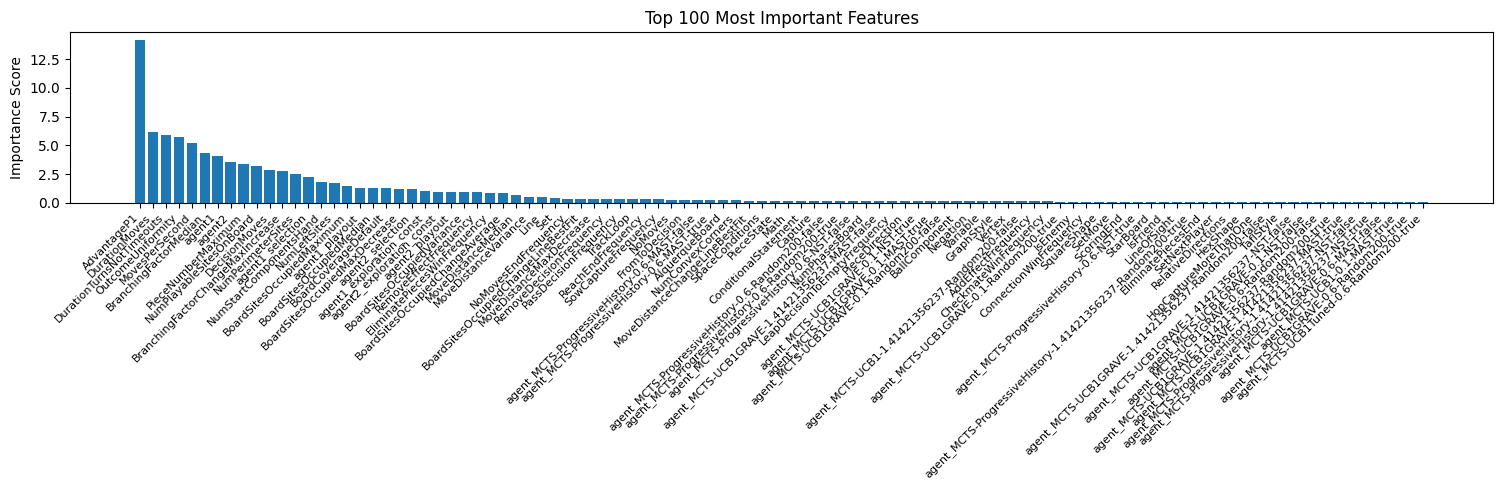

Fold 3 - RMSE: 0.4261072898337745
Fold 4


0:	learn: 0.6109317	test: 0.5647679	best: 0.5647679 (0)	total: 79.1ms	remaining: 3m 57s


50:	learn: 0.3928354	test: 0.4638430	best: 0.4638430 (50)	total: 3.88s	remaining: 3m 44s


100:	learn: 0.3543355	test: 0.4513308	best: 0.4510377 (97)	total: 8.1s	remaining: 3m 52s


150:	learn: 0.3302379	test: 0.4447312	best: 0.4447312 (150)	total: 12.1s	remaining: 3m 48s


200:	learn: 0.3144071	test: 0.4413588	best: 0.4413588 (200)	total: 16.1s	remaining: 3m 44s


250:	learn: 0.3020775	test: 0.4382835	best: 0.4382835 (250)	total: 20.3s	remaining: 3m 42s


300:	learn: 0.2920821	test: 0.4369892	best: 0.4368872 (295)	total: 24.3s	remaining: 3m 38s


350:	learn: 0.2841736	test: 0.4356289	best: 0.4355713 (348)	total: 28.4s	remaining: 3m 34s


400:	learn: 0.2769089	test: 0.4346302	best: 0.4346302 (400)	total: 32.6s	remaining: 3m 30s


450:	learn: 0.2709815	test: 0.4339218	best: 0.4339218 (450)	total: 36.7s	remaining: 3m 27s


500:	learn: 0.2654047	test: 0.4331331	best: 0.4331331 (500)	total: 41.1s	remaining: 3m 24s


550:	learn: 0.2607093	test: 0.4321519	best: 0.4321399 (549)	total: 45.2s	remaining: 3m 20s


600:	learn: 0.2569122	test: 0.4320458	best: 0.4320068 (593)	total: 49.6s	remaining: 3m 17s


650:	learn: 0.2531505	test: 0.4316866	best: 0.4316866 (650)	total: 53.8s	remaining: 3m 14s


700:	learn: 0.2493927	test: 0.4314344	best: 0.4314230 (698)	total: 58.1s	remaining: 3m 10s


750:	learn: 0.2459664	test: 0.4310746	best: 0.4310746 (750)	total: 1m 2s	remaining: 3m 6s


800:	learn: 0.2429293	test: 0.4309164	best: 0.4308463 (792)	total: 1m 6s	remaining: 3m 2s


850:	learn: 0.2393244	test: 0.4308098	best: 0.4306664 (840)	total: 1m 10s	remaining: 2m 58s


900:	learn: 0.2363879	test: 0.4304139	best: 0.4303607 (896)	total: 1m 14s	remaining: 2m 54s


950:	learn: 0.2336407	test: 0.4302092	best: 0.4302092 (950)	total: 1m 19s	remaining: 2m 50s


1000:	learn: 0.2311425	test: 0.4300798	best: 0.4300798 (1000)	total: 1m 23s	remaining: 2m 46s


1050:	learn: 0.2287059	test: 0.4301600	best: 0.4300559 (1002)	total: 1m 27s	remaining: 2m 42s


1100:	learn: 0.2262439	test: 0.4300445	best: 0.4300417 (1099)	total: 1m 31s	remaining: 2m 38s


1150:	learn: 0.2238729	test: 0.4299517	best: 0.4299025 (1143)	total: 1m 36s	remaining: 2m 34s


1200:	learn: 0.2215113	test: 0.4298850	best: 0.4298533 (1175)	total: 1m 40s	remaining: 2m 30s


1250:	learn: 0.2194262	test: 0.4297133	best: 0.4297105 (1249)	total: 1m 44s	remaining: 2m 26s


1300:	learn: 0.2172904	test: 0.4295769	best: 0.4295760 (1299)	total: 1m 48s	remaining: 2m 22s


1350:	learn: 0.2153753	test: 0.4293555	best: 0.4293555 (1350)	total: 1m 53s	remaining: 2m 17s


1400:	learn: 0.2133614	test: 0.4292703	best: 0.4292505 (1397)	total: 1m 57s	remaining: 2m 13s


1450:	learn: 0.2114859	test: 0.4292214	best: 0.4291653 (1417)	total: 2m 1s	remaining: 2m 9s


1500:	learn: 0.2097366	test: 0.4291638	best: 0.4291611 (1467)	total: 2m 5s	remaining: 2m 5s


1550:	learn: 0.2080238	test: 0.4291531	best: 0.4291531 (1550)	total: 2m 9s	remaining: 2m 1s


1600:	learn: 0.2062004	test: 0.4291627	best: 0.4291272 (1564)	total: 2m 14s	remaining: 1m 57s


1650:	learn: 0.2046949	test: 0.4291777	best: 0.4291272 (1564)	total: 2m 18s	remaining: 1m 53s


1700:	learn: 0.2030093	test: 0.4291473	best: 0.4291037 (1678)	total: 2m 22s	remaining: 1m 48s


1750:	learn: 0.2012664	test: 0.4291137	best: 0.4291037 (1678)	total: 2m 26s	remaining: 1m 44s


1800:	learn: 0.1996985	test: 0.4290856	best: 0.4290685 (1799)	total: 2m 31s	remaining: 1m 40s


1850:	learn: 0.1980714	test: 0.4290637	best: 0.4290580 (1843)	total: 2m 35s	remaining: 1m 36s


1900:	learn: 0.1964762	test: 0.4288930	best: 0.4288897 (1896)	total: 2m 39s	remaining: 1m 32s


1950:	learn: 0.1950217	test: 0.4288944	best: 0.4288511 (1915)	total: 2m 44s	remaining: 1m 28s


2000:	learn: 0.1934669	test: 0.4287571	best: 0.4287450 (1999)	total: 2m 48s	remaining: 1m 24s


2050:	learn: 0.1920214	test: 0.4286874	best: 0.4286776 (2044)	total: 2m 52s	remaining: 1m 19s


2100:	learn: 0.1905532	test: 0.4287771	best: 0.4286776 (2044)	total: 2m 56s	remaining: 1m 15s


2150:	learn: 0.1892500	test: 0.4287588	best: 0.4286776 (2044)	total: 3m	remaining: 1m 11s


2200:	learn: 0.1877864	test: 0.4287060	best: 0.4286776 (2044)	total: 3m 5s	remaining: 1m 7s


2250:	learn: 0.1863788	test: 0.4286781	best: 0.4286522 (2244)	total: 3m 9s	remaining: 1m 3s


2300:	learn: 0.1850754	test: 0.4286988	best: 0.4286522 (2244)	total: 3m 13s	remaining: 58.8s


2350:	learn: 0.1837831	test: 0.4286126	best: 0.4286119 (2349)	total: 3m 17s	remaining: 54.6s


2400:	learn: 0.1825966	test: 0.4286472	best: 0.4285955 (2358)	total: 3m 22s	remaining: 50.4s


2450:	learn: 0.1813801	test: 0.4286154	best: 0.4285706 (2446)	total: 3m 26s	remaining: 46.2s


2500:	learn: 0.1802378	test: 0.4285844	best: 0.4285706 (2446)	total: 3m 30s	remaining: 42s


2550:	learn: 0.1790683	test: 0.4285628	best: 0.4285591 (2548)	total: 3m 34s	remaining: 37.8s


2600:	learn: 0.1778967	test: 0.4284234	best: 0.4284185 (2596)	total: 3m 39s	remaining: 33.6s


2650:	learn: 0.1767530	test: 0.4283668	best: 0.4283527 (2635)	total: 3m 43s	remaining: 29.4s


2700:	learn: 0.1756607	test: 0.4283186	best: 0.4283169 (2698)	total: 3m 47s	remaining: 25.2s


2750:	learn: 0.1744612	test: 0.4283678	best: 0.4283023 (2707)	total: 3m 51s	remaining: 21s


2800:	learn: 0.1734619	test: 0.4283970	best: 0.4283023 (2707)	total: 3m 56s	remaining: 16.8s


2850:	learn: 0.1724108	test: 0.4284006	best: 0.4283023 (2707)	total: 4m	remaining: 12.6s


2900:	learn: 0.1713357	test: 0.4284029	best: 0.4283023 (2707)	total: 4m 4s	remaining: 8.35s


2950:	learn: 0.1702749	test: 0.4283799	best: 0.4283023 (2707)	total: 4m 8s	remaining: 4.13s


2999:	learn: 0.1692942	test: 0.4283508	best: 0.4283023 (2707)	total: 4m 13s	remaining: 0us

bestTest = 0.4283022852
bestIteration = 2707

Shrink model to first 2708 iterations.


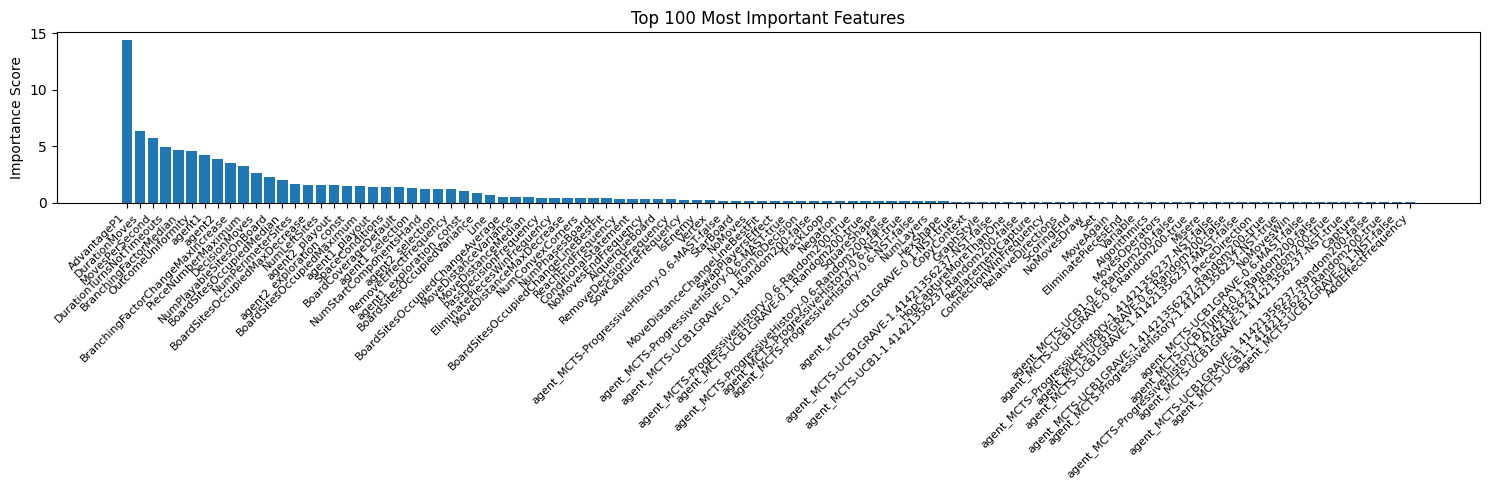

Fold 4 - RMSE: 0.42774820213845777
Fold 5


0:	learn: 0.6069569	test: 0.5794340	best: 0.5794340 (0)	total: 62.9ms	remaining: 3m 8s


50:	learn: 0.3901329	test: 0.4683968	best: 0.4683968 (50)	total: 3.9s	remaining: 3m 45s


100:	learn: 0.3530331	test: 0.4468241	best: 0.4468241 (100)	total: 8.14s	remaining: 3m 53s


150:	learn: 0.3290943	test: 0.4366511	best: 0.4366511 (150)	total: 12.3s	remaining: 3m 51s


200:	learn: 0.3145363	test: 0.4316714	best: 0.4316714 (200)	total: 16.5s	remaining: 3m 49s


250:	learn: 0.3034691	test: 0.4285540	best: 0.4285540 (250)	total: 20.7s	remaining: 3m 46s


300:	learn: 0.2943368	test: 0.4268745	best: 0.4268510 (298)	total: 24.9s	remaining: 3m 43s


350:	learn: 0.2870524	test: 0.4253892	best: 0.4252907 (346)	total: 29.2s	remaining: 3m 40s


400:	learn: 0.2804157	test: 0.4240768	best: 0.4240387 (399)	total: 33.4s	remaining: 3m 36s


450:	learn: 0.2746990	test: 0.4230018	best: 0.4230018 (450)	total: 37.8s	remaining: 3m 33s


500:	learn: 0.2691464	test: 0.4218983	best: 0.4218955 (499)	total: 42.1s	remaining: 3m 30s


550:	learn: 0.2638673	test: 0.4209648	best: 0.4208622 (542)	total: 46.4s	remaining: 3m 26s


600:	learn: 0.2589500	test: 0.4198979	best: 0.4198979 (600)	total: 50.6s	remaining: 3m 22s


650:	learn: 0.2544020	test: 0.4192802	best: 0.4192367 (649)	total: 54.9s	remaining: 3m 18s


700:	learn: 0.2498438	test: 0.4182635	best: 0.4182635 (700)	total: 59.2s	remaining: 3m 14s


750:	learn: 0.2464212	test: 0.4176175	best: 0.4176175 (750)	total: 1m 3s	remaining: 3m 10s


800:	learn: 0.2428496	test: 0.4173898	best: 0.4173863 (799)	total: 1m 7s	remaining: 3m 6s


850:	learn: 0.2397965	test: 0.4170629	best: 0.4170629 (850)	total: 1m 12s	remaining: 3m 2s


900:	learn: 0.2372353	test: 0.4167306	best: 0.4167306 (900)	total: 1m 16s	remaining: 2m 58s


950:	learn: 0.2345791	test: 0.4164085	best: 0.4164085 (950)	total: 1m 20s	remaining: 2m 54s


1000:	learn: 0.2320349	test: 0.4161538	best: 0.4161458 (999)	total: 1m 25s	remaining: 2m 50s


1050:	learn: 0.2291892	test: 0.4158120	best: 0.4158120 (1050)	total: 1m 29s	remaining: 2m 46s


1100:	learn: 0.2264675	test: 0.4156503	best: 0.4156492 (1099)	total: 1m 34s	remaining: 2m 42s


1150:	learn: 0.2240794	test: 0.4155300	best: 0.4155300 (1150)	total: 1m 38s	remaining: 2m 38s


1200:	learn: 0.2218532	test: 0.4154992	best: 0.4154528 (1184)	total: 1m 42s	remaining: 2m 34s


1250:	learn: 0.2196940	test: 0.4153295	best: 0.4153284 (1249)	total: 1m 47s	remaining: 2m 29s


1300:	learn: 0.2176897	test: 0.4151253	best: 0.4151087 (1284)	total: 1m 51s	remaining: 2m 25s


1350:	learn: 0.2155390	test: 0.4150323	best: 0.4150303 (1349)	total: 1m 55s	remaining: 2m 21s


1400:	learn: 0.2136389	test: 0.4147890	best: 0.4147890 (1400)	total: 2m	remaining: 2m 17s


1450:	learn: 0.2117649	test: 0.4145630	best: 0.4145307 (1437)	total: 2m 4s	remaining: 2m 12s


1500:	learn: 0.2100366	test: 0.4145747	best: 0.4145307 (1437)	total: 2m 8s	remaining: 2m 8s


1550:	learn: 0.2082850	test: 0.4145301	best: 0.4145301 (1550)	total: 2m 12s	remaining: 2m 4s


1600:	learn: 0.2066798	test: 0.4143897	best: 0.4143757 (1577)	total: 2m 17s	remaining: 1m 59s


1650:	learn: 0.2049909	test: 0.4143823	best: 0.4143757 (1577)	total: 2m 21s	remaining: 1m 55s


1700:	learn: 0.2032549	test: 0.4144474	best: 0.4143757 (1577)	total: 2m 25s	remaining: 1m 51s


1750:	learn: 0.2016534	test: 0.4144419	best: 0.4143580 (1722)	total: 2m 30s	remaining: 1m 47s


1800:	learn: 0.1999691	test: 0.4144238	best: 0.4143580 (1722)	total: 2m 34s	remaining: 1m 42s


1850:	learn: 0.1984268	test: 0.4144713	best: 0.4143580 (1722)	total: 2m 38s	remaining: 1m 38s


1900:	learn: 0.1968929	test: 0.4143142	best: 0.4143142 (1900)	total: 2m 42s	remaining: 1m 34s


1950:	learn: 0.1954926	test: 0.4143065	best: 0.4142995 (1945)	total: 2m 47s	remaining: 1m 29s


2000:	learn: 0.1940758	test: 0.4142279	best: 0.4142194 (1996)	total: 2m 51s	remaining: 1m 25s


2050:	learn: 0.1926564	test: 0.4142833	best: 0.4142194 (1996)	total: 2m 55s	remaining: 1m 21s


2100:	learn: 0.1912807	test: 0.4142504	best: 0.4142194 (1996)	total: 3m	remaining: 1m 17s


2150:	learn: 0.1900261	test: 0.4142875	best: 0.4142194 (1996)	total: 3m 4s	remaining: 1m 12s


2200:	learn: 0.1887923	test: 0.4144367	best: 0.4142194 (1996)	total: 3m 8s	remaining: 1m 8s


2250:	learn: 0.1874705	test: 0.4143966	best: 0.4142194 (1996)	total: 3m 13s	remaining: 1m 4s


2300:	learn: 0.1860779	test: 0.4144285	best: 0.4142194 (1996)	total: 3m 17s	remaining: 1m


2350:	learn: 0.1848626	test: 0.4143763	best: 0.4142194 (1996)	total: 3m 21s	remaining: 55.7s


2400:	learn: 0.1836040	test: 0.4144036	best: 0.4142194 (1996)	total: 3m 26s	remaining: 51.4s


2450:	learn: 0.1824145	test: 0.4143960	best: 0.4142194 (1996)	total: 3m 30s	remaining: 47.1s


2500:	learn: 0.1811927	test: 0.4143312	best: 0.4142194 (1996)	total: 3m 34s	remaining: 42.8s


2550:	learn: 0.1799979	test: 0.4143786	best: 0.4142194 (1996)	total: 3m 39s	remaining: 38.5s


2600:	learn: 0.1787469	test: 0.4143283	best: 0.4142194 (1996)	total: 3m 43s	remaining: 34.3s


2650:	learn: 0.1776585	test: 0.4143340	best: 0.4142194 (1996)	total: 3m 47s	remaining: 30s


2700:	learn: 0.1765456	test: 0.4143234	best: 0.4142194 (1996)	total: 3m 51s	remaining: 25.7s


2750:	learn: 0.1754661	test: 0.4142859	best: 0.4142194 (1996)	total: 3m 56s	remaining: 21.4s


2800:	learn: 0.1743599	test: 0.4143062	best: 0.4142194 (1996)	total: 4m	remaining: 17.1s


2850:	learn: 0.1733394	test: 0.4142842	best: 0.4142194 (1996)	total: 4m 4s	remaining: 12.8s


2900:	learn: 0.1722725	test: 0.4143545	best: 0.4142194 (1996)	total: 4m 9s	remaining: 8.51s


2950:	learn: 0.1712141	test: 0.4144248	best: 0.4142194 (1996)	total: 4m 13s	remaining: 4.21s


2999:	learn: 0.1700983	test: 0.4144298	best: 0.4142194 (1996)	total: 4m 17s	remaining: 0us

bestTest = 0.4142193522
bestIteration = 1996

Shrink model to first 1997 iterations.


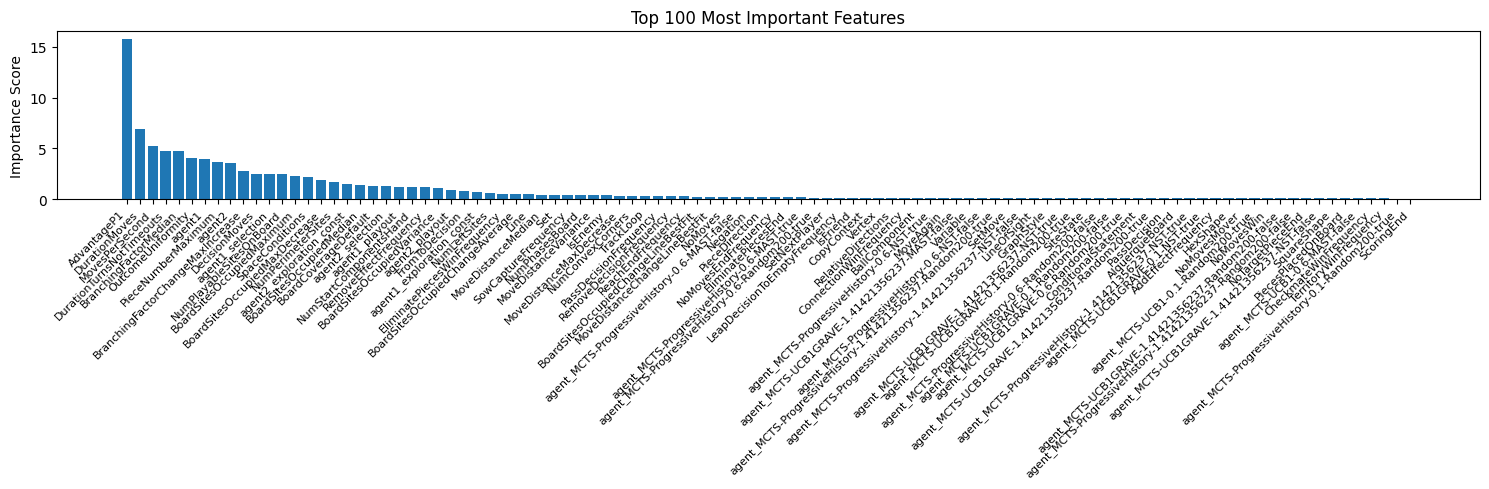

Fold 5 - RMSE: 0.4137595932214679
List of oof scores: [0.42540093045396526, 0.41667572179083207, 0.4261072898337745, 0.42774820213845777, 0.4137595932214679]
Average oof score: 0.42193834748769954


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4249
Score: 0.4300
Score: 0.4138
Score: 0.4288
Score: 0.4043
Average CV1 Score: 0.4204

CV2 OOF Scores:
Score: 0.4066
Score: 0.4014
Score: 0.4245
Score: 0.4327
Score: 0.4203
Average CV2 Score: 0.4171

CV3 OOF Scores:
Score: 0.4254
Score: 0.4167
Score: 0.4261
Score: 0.4277
Score: 0.4138
Average CV3 Score: 0.4219


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

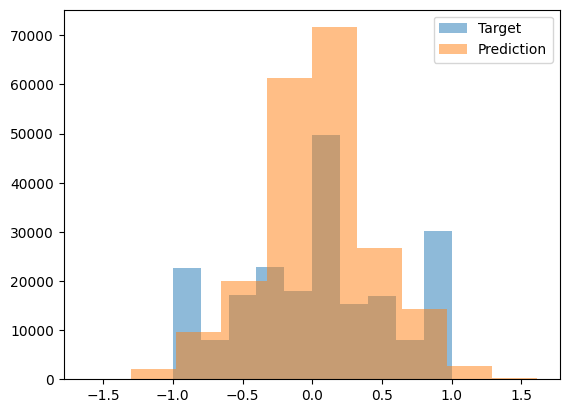

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.15179        │
│ 233235 ┆ -0.152008      │
│ 233236 ┆ -0.051629      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***